# Computer Vision - Assignment 2 - Deep Learning for Computer Vision

#### 10 points   |   Due date: March 24, 23:59   |   Submission site: https://pradoposgrado2324.ugr.es/

### Student's Full Name: <mark>Seyedeh Kimia Arfaie Oghani</mark>

The goal of this assignment is to learn how to implement and use Convolutional Neural Networks using the fastai library (https://docs.fast.ai/).

<font color='blue'>The goal of this assignmnet is to gain experience designing and training deep neural networks (in particular, convolutional neural networks). From a base network architecture that is provided, you have to learn to perform experiments with it and to improve it by adding, modifying or deleting layers.

<font color='blue'>A help guide (`Assignment_2_HG.ipynb`) is also provided to know how:
1. Basic functions of reading data, training and optimization can be performed;
2. Graphs for the evolution of the classification error in
the training and validation sets can be created;
3. The classification error in the test set can be computed.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Exercise 1: BaseNet in CIFAR100 (3 points)**

<font color='blue'>*Dataset:*
In this exercise, we will work with part of the CIFAR100 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). This dataset consists of 60K color images of 32x32x3 (RGB) depicting 100 different classes (600 images per class). There are 50K images for training and 10K for testing. For the development of the exercise we will only consider 25 classes (out of 100). Therefore, the training set has 12,500 images and the test set 2,500 images. 10% of the training set will be used for validation.

<font color='blue'>**Model BaseNet:**
We start by creating a base model called *BaseNet* which, after its training and execution, will give us a classification error which will be used as reference or baseline for further improvements.

<font color='blue'>Our BaseNet model consists of two convolutional blocks (Conv+ReLU) at different scales (MaxPooling), and one head composed of two fully-connected (FC) layers (also called dense layers). The precise architecture is defined in the table below:

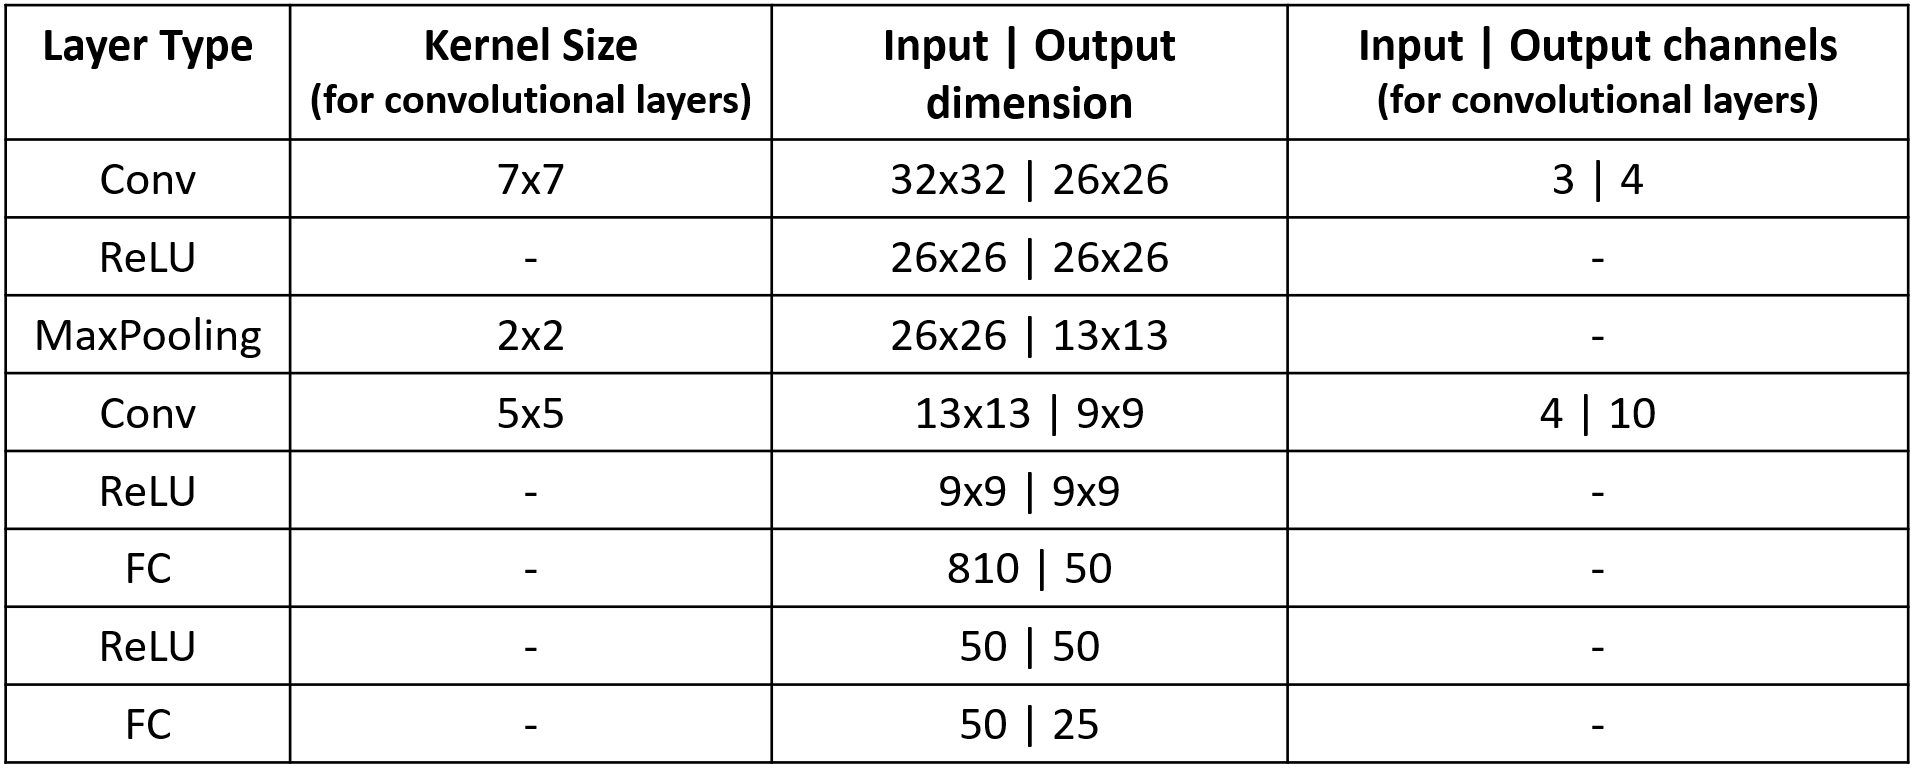


<font color='blue'>The students must:
1. Become familiar with the *BaseNet* architecture described above, the meaning of the different hyperparameters and the purpose of each layer. Create the code for the *BaseNet* model employing the fastai library.
2. Train the model (justifying all decisions made) and evaluate its performance. To do so, you should employ: the confusion matrix in training and testing; the accuracy in training, validation and test; and the evolution of both the loss function (in training and validation) and accuracy (in validation) with respect to the training epochs.

<font color='blue'>Note: This is the base model that we will try to improve in the next section. In this sense, it is not necessary to carry out a very sophisticated or complex training procedure. In any case, it is not advisable to use the default values of functions without having a justification for it. One must demonstrate that he/she understands what is doing, as well as what the framework does underneath.

In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/test'), Path('/root/.fastai/data/cifar100/train')]
[Path('/root/.fastai/data/cifar100/train/flowers'), Path('/root/.fastai/data/cifar100/train/vehicles_1'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/food_containers'), Path('/root/.fastai/data/cifar100/train/trees'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/vehicles_2'), Path('/root/.fast


"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)." https://github.com/fastai/dlcert2/blob/master/docs/datasets.md

In [ ]:
# We want to verify that within each of the 20 superclasses there are 5 classes,
# which gives the 100 classes there are. We also want to verify that the number of images is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Number of classes within superclass ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

In [ ]:
# We keep the first 25 classes (we remove the last 75 from the dataset)
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('REMOVED SUPERCLASSES:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASSES WE KEEP:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

In [ ]:
# We also remove the classes from the test set
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

In [ ]:
# Now we check if we have remove them correctly
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


In [ ]:
# And that the number of examples in training and test is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Classes within the first superclass ( /root/.fastai/data/cifar100/train/flowers ):  [Path('/root/.fastai/data/cifar100/train/flowers/rose'), Path('/root/.fastai/data/cifar100/train/flowers/poppy'), Path('/root/.fastai/data/cifar100/train/flowers/sunflower'), Path('/root/.fastai/data/cifar100/train/flowers/tulip'), Path('/root/.fastai/data/cifar100/train/flowers/orchid')]
Total training images:  12500
Total test images:  2500


**1.Data Loading**

First step is creating a dataloader. In this step we are aiming to turn our data into a DataLoaders object. We use 'DataBlock', which is a high level abstraction, allowing us to put together a pipeline for creating a DataLoaders object. The 'DataBlock' API allows us to define the type of data we are working with (mageBlock, CategoryBlock), how to get our data (get_items), how to split it into a training and validation set (RandomSplitter(valid_pct=0.1, seed=42)), how to label it (get_y = parent_label), and how to apply different transformations on it. Since, in this first part of the exercise, there is no need to necessarily carry out a very sophisticated or complex training procedure, we just specify the type of data, collect it, put 10% of trainind data as validation set, and get the labels. I also chose batch size of 32, as suggested in the paper "Revisiting Small Batch Training for Deep Neural Networks" by D. Masters, stating that small mini-batch sizes provide more up-to-date gradient calculation, and best performances have been obtained by mini-batch sizes of between 2 and 32. Also, since all the images in the dataset are of the same size of 32x32, I didn't resize them.

Then, nine random images of the train set were shown.

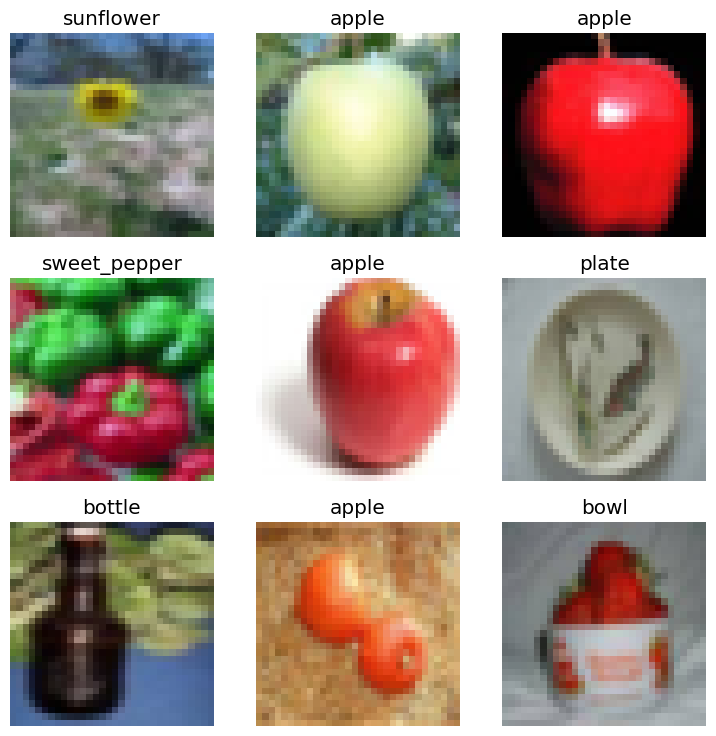

In [ ]:
#Data Block
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Specify data types
    get_items=get_image_files,  # Collect data items
    splitter=RandomSplitter(valid_pct=0.1,seed=42),  # 10% is for validation set
    get_y=parent_label,  # Label items based on folder names
)

# create the data loader
dls = db.dataloaders(path, bs=32)

# To show a batch from the training set
dls.show_batch(max_n=9)

**2. Creating the Learner object**

**First** of all, for creating the network, we use sequential, which is a container that will process the input data sequentially, layer by layer. The architecture follows as below:

First Convolution: Since the input is 32x32, with input channel of 3, based on the formula that:

output = ((input - kernel * 2*padding ) / stride) + 1,

We can say that padding is 0 and stride is 1, so the output dimension would be 26x26: 32-7+0/1 + 1; since we have 4 kernels, the output would be 26x26 and the output channel of 4.

Then, we have the ReLU activation function. The ReLU (rectified linear unit) activation function, sets input values of negative to zero, and returns positive values as they are; introducing nonlinearity into the model. The dimensions in this layer don't change. So in this layer, the dimensions are still 26x26x4.

Then, we have MaxPooling. This operation, is a pooling operation, that calculates the maximum value for patches of the feature map, in order to reduce dimensionality as we go deeper into the network. Here, the size is 2x2, so we calculate the maximum of the feature map in 2x2 windows and replace it in the output. MaxPooling adds a certain amount of translation invariance, meaning translating the image by a small amount does not significantly affect the values of the most pooled outputs. Again, according to the formula, with input dimension of 26x26 and output dimensions of 13x13, we can say that the padding is 0, and the stride is 2; 13 = 26-2+0/2 + 1. We still have 4 channels, so the output is 13x13x4.

Second Convolution: Since the input is 13x13 with an input channel of 4, based on the formula, since the output dimension is 9x9, the stride is 1, and padding is 0 again: 13-5+0/1 + 1 = 9. Given the fact that the output channel is 10, the output dimension is 9x9x10.

Again we have the ReLU activation function with input and output of 9x9x10 dimentions.

Before going to the Fully connected layers, we need to flatten the features, allowing to pass from a volme (set of feature maps) to a vector (that can be processed by a FC layer later).

Next, we have Fully Connected layers. In these layers, all the units in one layer are connected to all units of the next layer, which are usually placed at the end of the network. Since we had a volume of 9x9x10 which was flattened in the previous section, we now have 810 elements as input, and 50 as output.

In the end, after a ReLU activation function, we have another FC layer, that connects 50 units to 25 units.

**Second**, in order to create the Learner object, we should include the model (simpleNet), the data loader (dls), and the loss function (loss_func) in the suitable function. Then the training can begin.

In [ ]:
# Create the body of the network

simpleNet = sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(7,7), stride=1),  # Output size: 26x26x4
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),  # Output size: 13x13x4
    nn.Conv2d(in_channels=4, out_channels=10, kernel_size=(5,5), stride=1),  # Output size: 9x9x10
    nn.ReLU(),
    nn.Flatten(),  # Flatten the output for fully connected layer, 9x9x10 = 810 elements
    nn.Linear(in_features=810, out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50, out_features=25),
    # Softmax is not needed since it is combined with CrossEntropyLoss
)

**3. Training SimpleNet**

We use the fit method to train our model for a certain number of epochs. During the training, we used the one-cycle learning rate criteria from Leslie Smith to accelerate convergence in optimization. (https://arxiv.org/abs/1803.09820, https://arxiv.org/abs/1708.07120). learn.fit_one_cycle trains the model for a certain number of epochs using the mentioned policy.

The one-cycle policy:

The policy operates under a simple intuition: start training with a low learning rate, increase it gradually for the first part of training to a certain maximum value, and then decrease it towards the end for the next half. The idea is to allow the network to explore the loss landscape initially with a small learning rate, then converge to a good area of the loss landscape using a higher learning rate, and finally refine its position in that area with a smaller learning rate again. During this increase and then decrease in the learning rate, the momentum is also gradually decreasing and then increasing.

This approach enables accelerated training; we determine the maximum learning rate to apply in the one-cycle policy using the Learning Rate Finder: learner.lr_find(). This method increases the learning rate from a very small value to a very high value and records the loss at each point. The lr_find method plots these losses against the learning rates, and we can pick the learning rate where the loss starts to decrease before it diverges as our lr_max. This value is used as the maximum learning rate in the one-cycle policy. The plot can be seen in the next section.
This assists in selecting a learning rate that is neither too high nor too low. Our goal is to select the highest possible learning rate that still allows for convergence, ensuring effective training progress.
Here, a range of values for the learning rate is set by fixing a maximum value. This maximum value is chosen by observing/analyzing the shape of the lr_find() output curve.

0.0004786300996784121


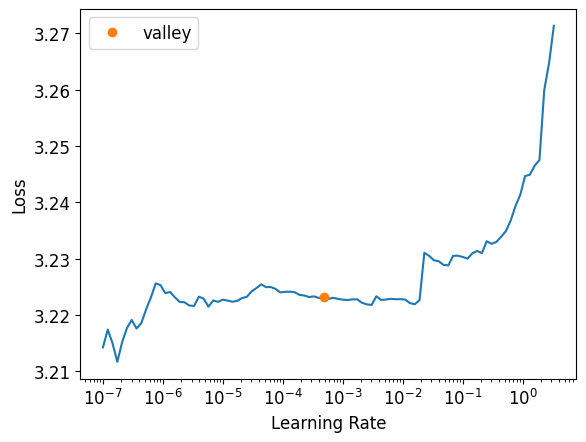

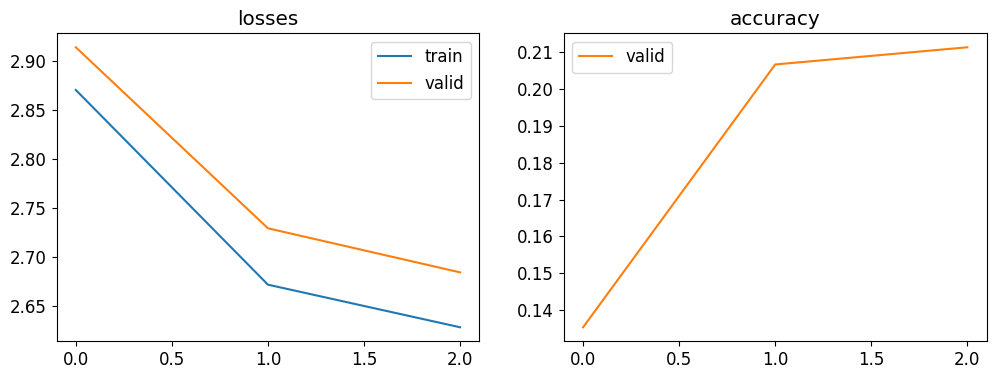

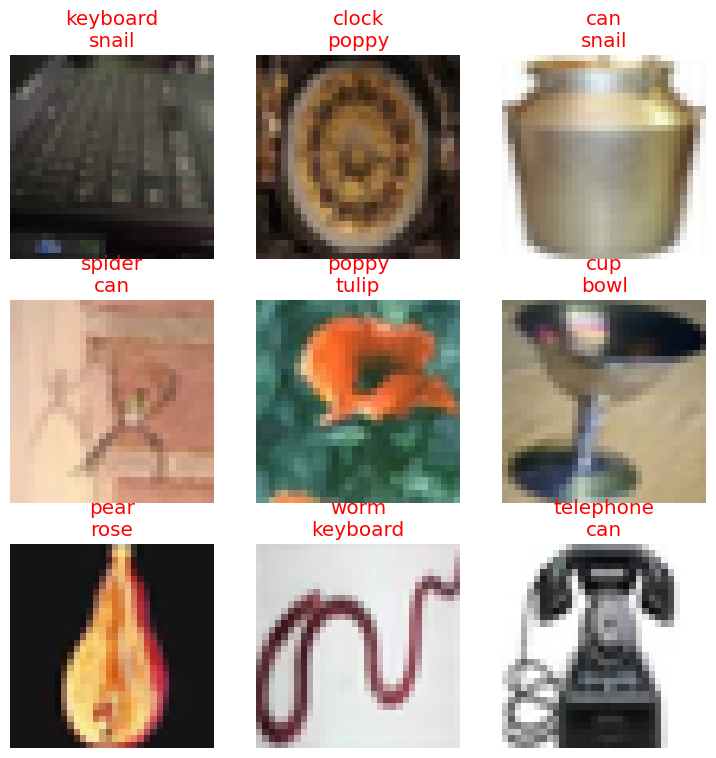

In [ ]:
# Creating the learner object
lobject1 = Learner(dls, simpleNet, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

lb1=lobject1.lr_find() # find the maximum value for lr to use in the next call to the optimizer
print(lb1[0])

# Train the network
lobject1.fit_one_cycle(n_epoch=3, lr_max=lb1[0]) # running the optimizer one-cycle

# Evaluating the model
lobject1.recorder.plot_metrics() # Shows accuracy curve along epochs

lobject1.show_results()

**4. Creating the confusion Matrix for the Train Set and calcualte the accuracy for training**

A confusion matrix is a table often used to describe the performance of a classification model on a set of data (here the train data) for which the true values are known. It is especially useful for measuring the accuracy of the performance. Looking at the table we see that the diagonal cells in the matrix (from top left to bottom right) represent correct classifications by the model, while off-diagonal cells are misclassifications.

First, the ClassificationInterpretation.from_learner() function creates an object that allows us to interpret the model's performance on the training dataset.

Then, interp.confusion_matrix() generates the confusion matrix from the interp object.

The accuracy calculation np.sum(np.diagonal(cm))/np.sum(cm)*100 computes the model's accuracy on the training set as follows:

1. np.diagonal(cm) gets the values on the diagonal of the confusion matrix, which are the numbers of correct predictions for each class. np.sum(np.diagonal(cm)) sums these values to get the total number of correct predictions.

2. np.sum(cm) calculates the sum of all values in the confusion matrix, which represents the total number of predictions made.

3. The division of the sum of correct predictions by the total number of predictions yields the proportion of correct predictions (the accuracy).


Train Accuracy
23.711111111111112


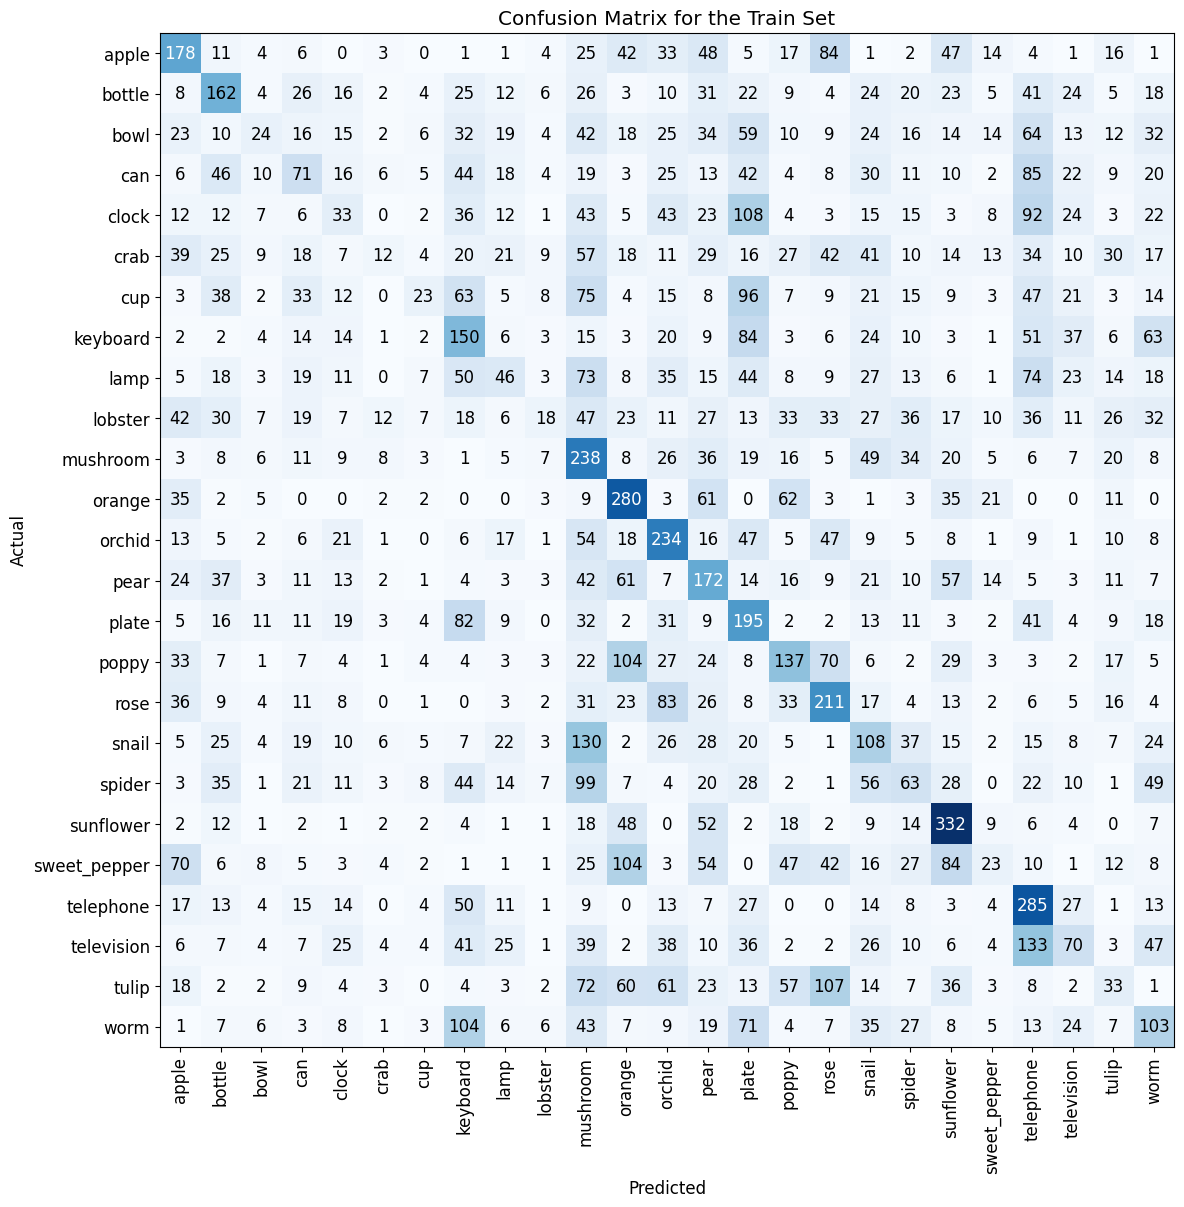

In [ ]:
# We compute the confusion matrix for train set
interp = ClassificationInterpretation.from_learner(lobject1, 1, dls.train)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Train Set')
print('Train Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

**5. Testing the model**

Now, use the network on the test set and get the model's predictions with the learner.get_preds() function. The get_preds function in the Fastai library is used to obtain the predictions of a learner object for a given dataset. "preds" stands for "predictions"; this variable will contain the raw output from the network for each item in test_dl. Since our problem is a classification problem, these will be the probabilities for each class.
"targs" stands for "targets." These are the true labels for each item in test_dl. The get_preds function grabs these from the dataset so we can compare the network's predictions against the actual truth.

In [ ]:
# Getting the dataloader for test data
test_dl = lobject1.dls.test_dl(files_test,with_labels=True)

# Getting the predictions of the network for the test data
preds, targs = lobject1.get_preds(dl=test_dl)


**6. Compute the accuracy of the Test**

In this section, I used the accuracy function to compute the accuracy of the test. The accuracy function compares the predicted labels with the true labels. For each prediction, it determines if the highest probability corresponds to the correct label. The accuracy is then calculated as the number of correct predictions divided by the total number of predictions, giving a value between 0 and 1. Then, we convert this output to a percentage, by multiplying it by 100.

In [ ]:
# We compute accuracy
acc1 = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc1)*100, 4), '%')

The test accuracy is :  24.16 %


**7. Create the confusion matrix for the Test**

Test Accuracy
24.16


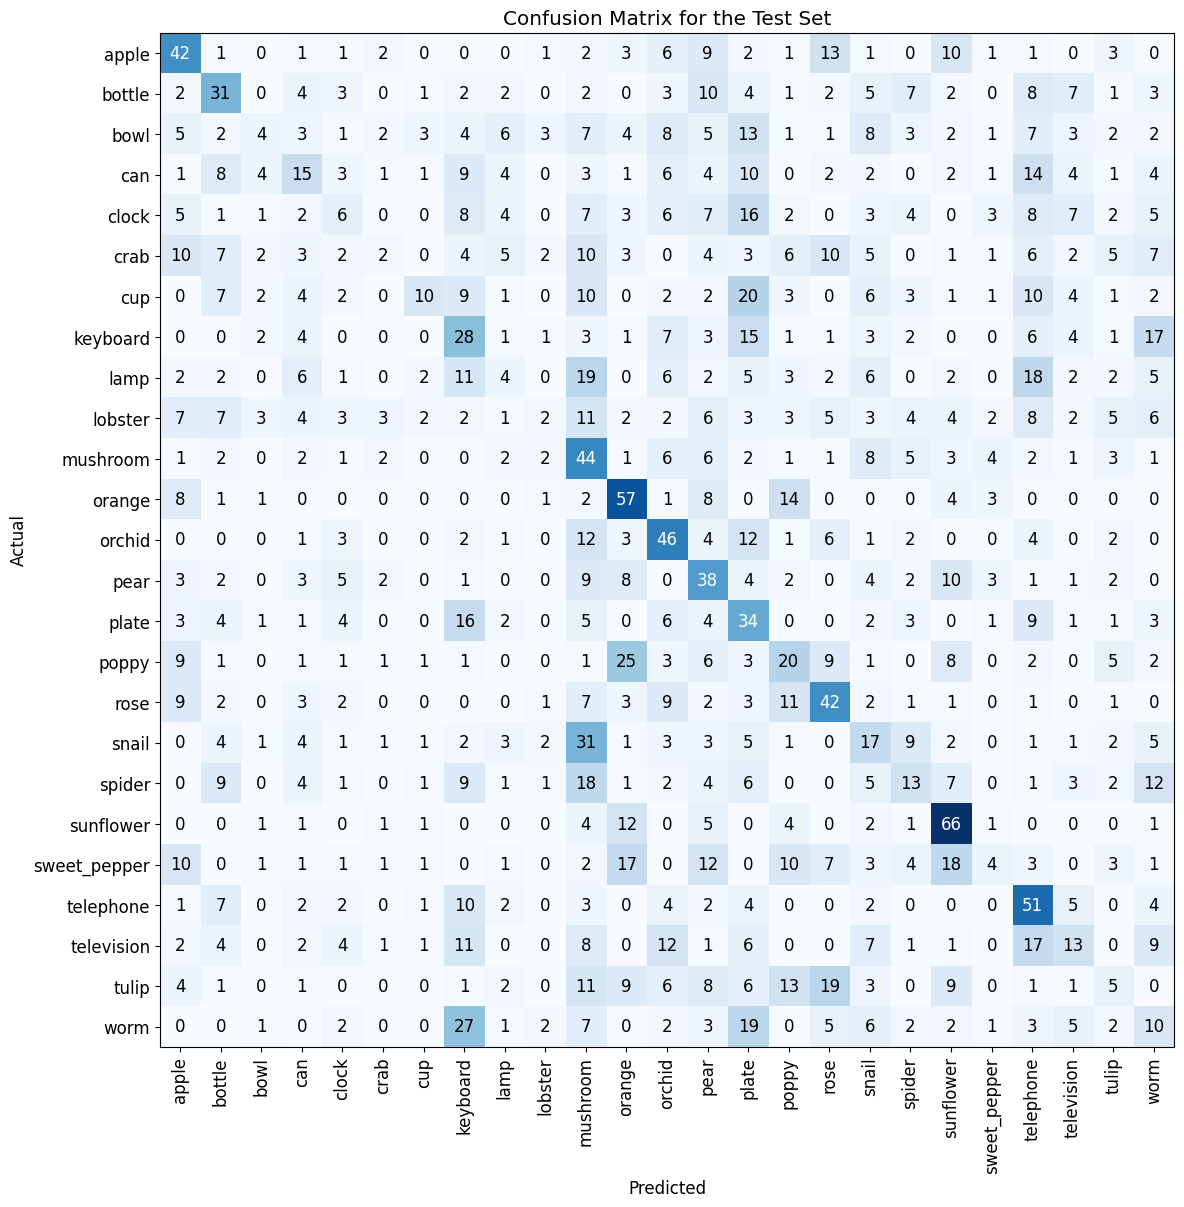

In [ ]:
# We compute the confusion matrix
interp = ClassificationInterpretation.from_learner(lobject1, 1, test_dl)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

**Discussion**

Looking back at the plots and accuracies on validation, train and test set we can say:

The losses plot shows both training and validation losses decreasing, which indicates that the model is learning. Also, the validation accuracy is increasing throughout the training which is good also.

Looking at the calculated accuracies, we can say that the performance is not relatively high, with validation accuracy being 21%, train accuracy being 23%, and test accuracy being 24%. This indicates that the network needs further improving which we are going to explore in the next exercise.

<font color='blue'>What is the total number of parameters of the created model? Break down the account made to reach that figure.



1. First Convolution: For each convolution, we know that the network should learn the elements, so the parameter for p kernels of the dimention of nxnxm would be : (nxnxm + 1 (bias))xp --> (7x7x3 + 1)x4 = 592

2. Second Convolution: based on the formula: (5x5x4+1)x10 = 1010

3. 1st FC layer: 810x50 + 50 = 40550
4. 2nd FC layer: 50x25+25 = 1275

Combining all the calculation we will have 43,427 parameters which our network has to learn.
Note that layers such as ReLU and MaxPooling don't add any new parameters to the network.

<font color='blue'>When fastai is used, and a multiclass classification problem like the one indicated in this exercise is addressed, is it necessary to incorporate a SoftMax function (`nn.Softmax()`) as last layer/element/component of your model? Justify the answer.

The nn.Softmax() layer is an activation function commonly used in the final part of a classification network to convert/normalize the output of a network into probabilities for each class. However, when using PyTorch's CrossEntropyLoss (as we are doing), we should not apply a softmax layer before it. Looking at the documentation of CrossEntropyLoss in PyTorch, we see that this loss function, uses LogSoftmax on an input, followed by NLLLoss (negative log likelihood loss), meaning it applies the softmax internally as part of the loss computation.



---



---



---



# <font color='blue'> **Exercise 2:** **Improvement of the BaseNet model (3.5 points)**
<font color='blue'>Now the goal is to create, by making judicious architectural and implementation choices, an enhanced deep network based on *BaseNet*. Students should perform a sensible combination of different elements, which may include all or some of the following: Convolutional layers (Conv2D, either normal or atrous), Pooling layers (Local and Global MaxPooling2D and AveragePooling2D), Dense layers (also called fully-connected (FC) layers), Non-linear activations, (e.g. ReLu, leaky ReLu, etc.), Flattening (i.e. convert 2D features to 1D features),  Batch Normalization, and/or Regularization (e.g. Dropout or weight decay).

<font color='blue'>It is necessary to emphasize that **it is essential to justify the decisions made in the best possible way** (either through empirical evidence or through scientific literature). It is also essential to highlight that **the improvements made must be carried out incrementally**, that is, it is not enough to create a single model directly and evaluate it. **It is necessary to justify and describe what steps and results have led us to conclude that this model (specific combination of constituent blocks) is appropriate**. It is absolutely essential to describe each of the improvements incorporated, as well as analyze the results obtained.

<font color='blue'>A good combination of layers can largely improve the performance of our new model on these data. To enhance your network, you may consider adding any combination of the following enhancement options:
1. **Data normalization**. Scale normalization of the input data, in general, makes training easier and more robust. Use the DataBlock class with the correct parameters so that the data is well conditioned (mean=0, stddev=1) to improve training. You must ensure that the test set uses the same normalization parameters as the ones employed in training.
2. **Batch normalization**. Batch-normalization layers in most cases help to reduce overfitting and improve model training. Add normalization layers after convolutional layers and before the ReLU layer, but try including it after ReLU layers as well.
3. **Depth increase**. Experiment adding convolutional layers. Do not always put a maxpool layer after each conv layer, as this leads to excessive loss of information by reducing the number of units. If needed use UpSampling (Transposed Convolution) layers to increase the number of units.
4. **Dropout**. This layer introduces regularization by randomly selecting a percentage of active neurons for each mini-batch. This helps the network to specialize neurons in specific and independent information.
5. **Early Stopping**. After how many epochs we should stop training? Keep in mind that you should never use the test set for anything other than the final evaluation. You should decide for how many epochs you will train your model by looking at the training loss and validation accuracy plots (to do so, evaluate the local minima/maxima of the loss function as well as the classification accuracy). Remember that if you choose too many epochs it would quite likely lead to overfitting, while if you select too few your model quite likely won't  learn enough. In your report, you must include a table similar to the one shown in Exercise 1 to illustrate the architecture of your final improved network. In addition, you must explain the steps taken with the partial results obtained that have finally led you to introduce the proposed modifications.
6. **Data augmentation**.  Use the DataBlock class to perform data augmentation, like zoom_range and/or horizontal_flip. Remember that, in general, you should not have any data augmentation in the validation or test sets.

<font color='blue'> Feel free to incorporate modifications not included in the aforementioned list.

**1. Making the model more complex (SimpleNet2) and adding Data Augmentation**

A) Looking at the first convolution in the SimpleNet, we see that, with the 7x7 kernel, we are going from 32x32 to 26x26 dimensions which may be a little too drastic, and we may lose information too early in the network; more than we want to. Therefore, I chose to use smaller kernels, back-to-back 3x3 kernels, to have denser computation, instead of having a 7x7 kernel right at the beginning of the network.

Adding consecutive convolution layers with 3x3 kernels introduces a deeper hierarchy of feature extraction. This depth enables the network to learn more complex features of the input data. The choice of 3x3 kernels is based on the previous practices done in this field, that favor multiple stacked smaller filters over a single larger filter, for increased non-linearity and depth without a drastic increase in parameters (for instance the use of 3x3 filters in VGGNET). We use smaller filters, and we increase the number of filters as we go deeper into the network; as spatial size decreases, the number of filters increases. We also add more non-linearity, and make the network deeper by doing this.

Therefore, in simpleNet2, first I have two 3x3 convolution layers, first with padding of 1, then no padding. The choice of including padding in the first two convolution layers is that I don't want the dimension to decrease so early in the network; this allows me to have a deeper network and more convolutions in the next layers (also, to preserve more of the image during the first convolution).

Then, in the next two convolutions, we have no padding, as I want to decrease the dimension now, extracting features.

Then, I have maxpooling as before, in order to reduce the dimension.

Also, I added another FC layer, to go from 40x6x6 units to 500 to 100 to 25.

Note:

Also, since I am making the model more complex, in order to prevent the model from overfitting, I added data augmentation to the train data. We should take into account that by adding this transformation in the datablock, augmentation is performed only on the train data and not the test data. We know that deep learning models perform well when we have a large amount of data. We can increase the number of training data, using data augmentation by transformations on the data such as mirroring, flipping, zooming, etc. Also, this method is used to improve the performance of the models by reducing overfitting (a regularization method). Since we are adding data augmentation, I will create a new dataloader object. Here, I only used zooming with a max zoom of 1.1 and a horizontal flip. I didn't want the augmentation to be too aggressive; as we know too much data augmentation can lead to decreased performance on the test set.

In [ ]:
# 1.1 New DataLoader, with augmentation added

# Data Block
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Specify data types
    get_items=get_image_files,  # Collect data items
    splitter=RandomSplitter(valid_pct=0.1,seed=42),  # 10% is for validation set
    get_y=parent_label,  # Label items based on folder names
    batch_tfms=[*aug_transforms(do_flip=True, flip_vert=False, max_zoom=1.1)] # Only horizontal flip and zooming
)

# New Data Loader with data augmentation included
dls = db.dataloaders(path, bs=32)

In [ ]:
# 1.2 Creating the new network, simpleNet2
simpleNet2 = sequential(
    # Increase initial depth and utilize 3x3 kernels for better feature extraction
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3,3), stride=1, padding=1), #32x32
    nn.ReLU(),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3,3), stride=1, padding=1), #32x32
    nn.ReLU(),
    # First pooling to reduce spatial dimensions
    nn.MaxPool2d(kernel_size=(2,2), stride=2), #16x16

    # Transition to even deeper layers with 3x3 kernels
    nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3,3), stride=1, padding=0), #14x14
    nn.ReLU(),
    nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(3,3), stride=1, padding=0), #12x12
    nn.ReLU(),

    # Implement a final max pooling to reduce dimensions before fully connected layers
    nn.MaxPool2d(kernel_size=(2,2), stride=2), #6x6

    # Flatten the output for fully connected layers
    nn.Flatten(),

    # FC Layers
    nn.Linear(in_features=40*6*6, out_features=500),
    nn.ReLU(),

    nn.Linear(in_features=500, out_features=100),
    nn.ReLU(),

    nn.Linear(in_features=100, out_features=25),
)


0.0003311311302240938


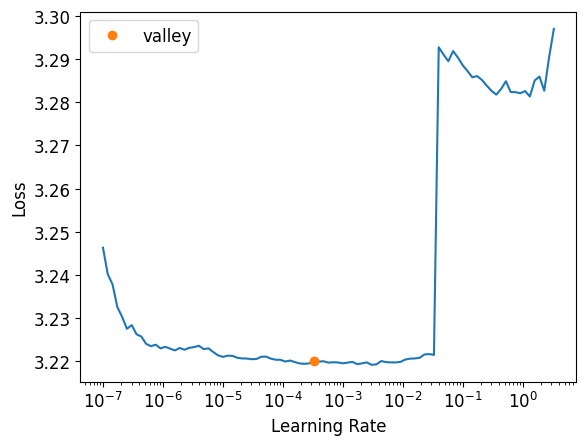

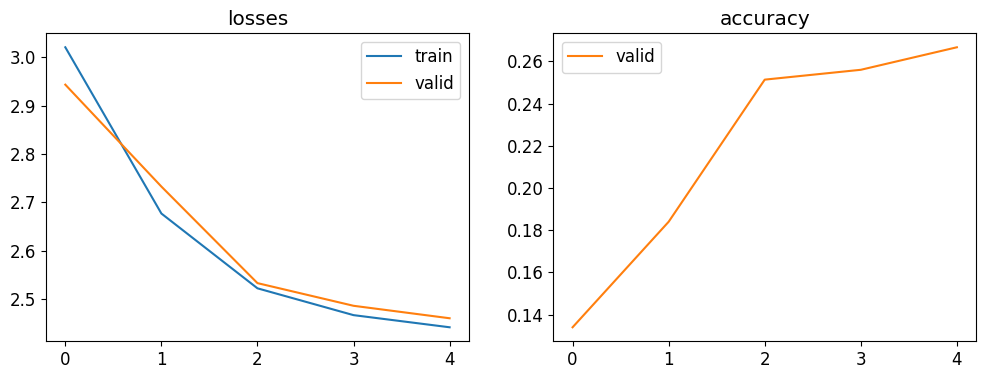

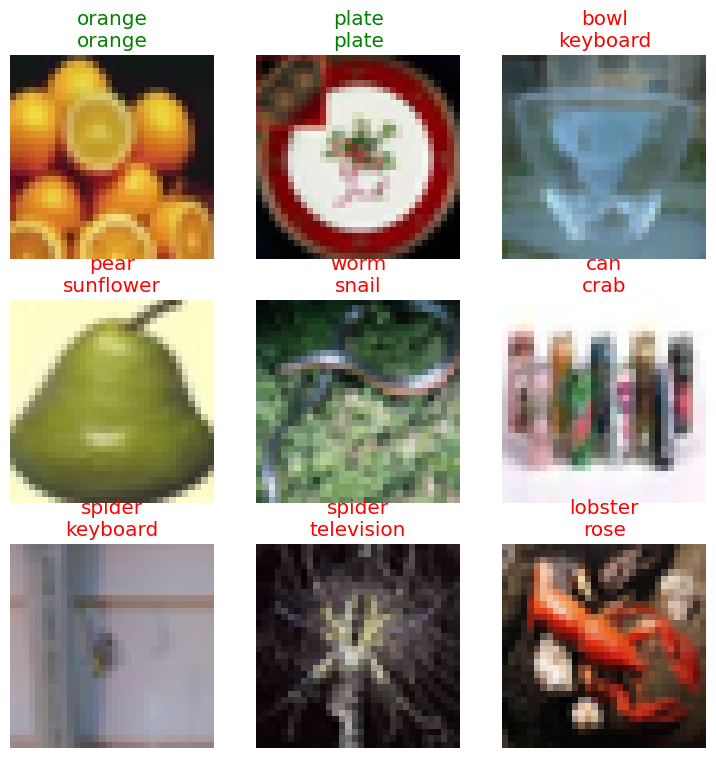

In [ ]:
#1.3 Learner object and training, using dls with augmentation
learn_2 = Learner(dls, simpleNet2, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

max2 = learn_2.lr_find() # Find the maximum value for lr to use in the next call to the optimizer
print(max2[0])

learn_2.fit_one_cycle(n_epoch=5, lr_max=max2[0]) # running the optimizer one-cycle

# Evaluating the model
learn_2.recorder.plot_metrics() # Shows accuracy curve along epochs

learn_2.show_results()

Train Accuracy
28.46666666666667


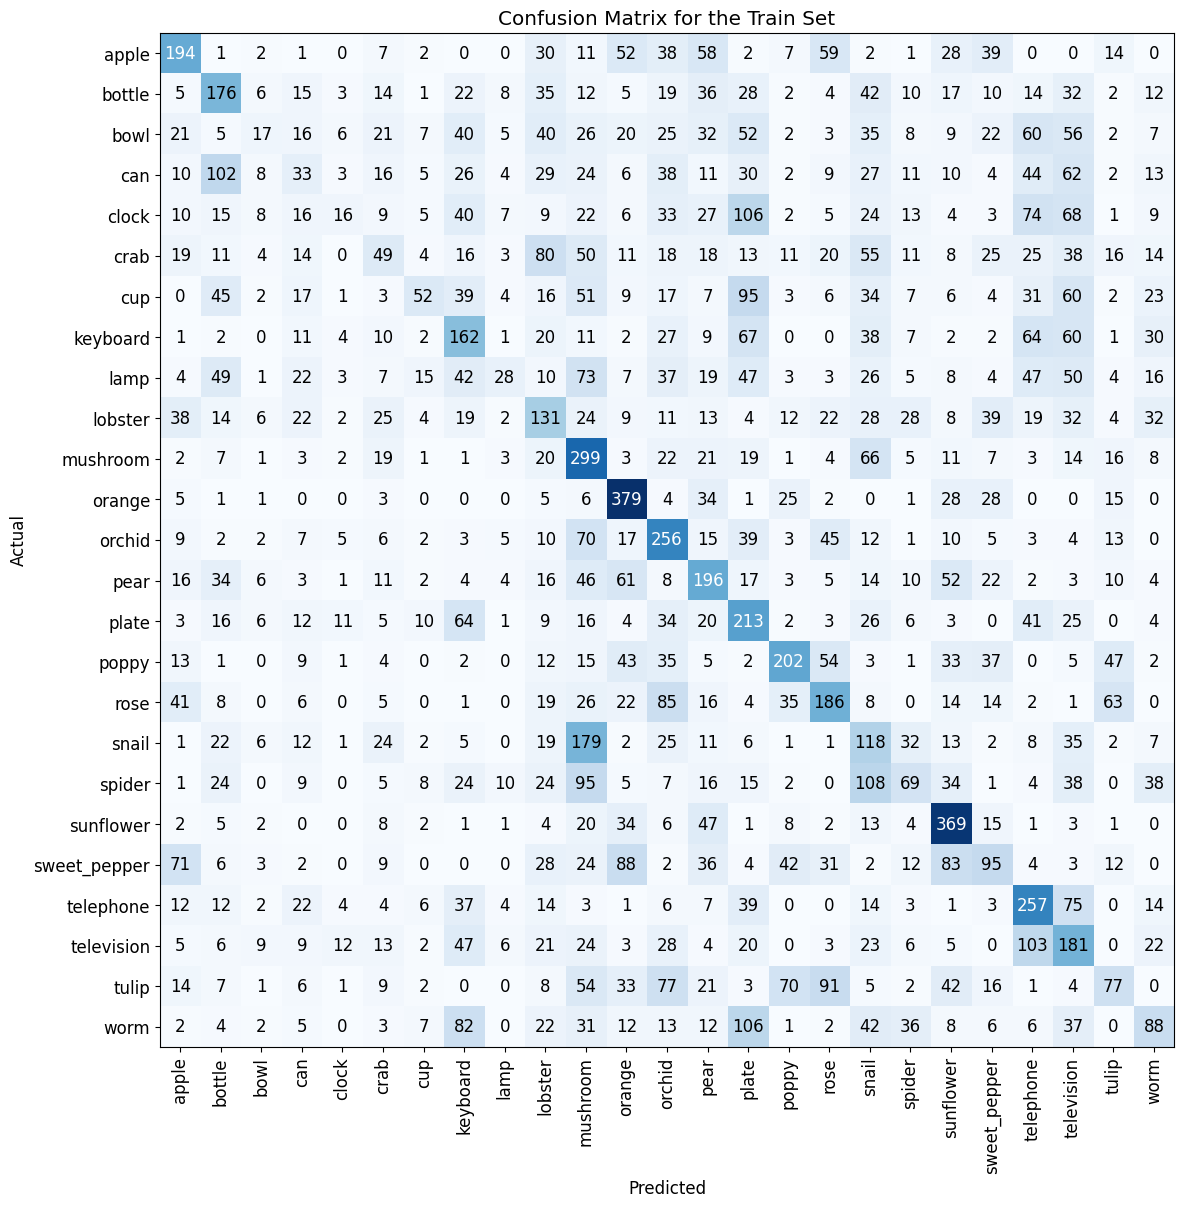

In [ ]:
#1.4 We compute the confusion matrix and Accuracy for Train set
interp = ClassificationInterpretation.from_learner(learn_2, 1, dls.train)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Train Set')
print('Train Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

Test Accuracy
28.599999999999998


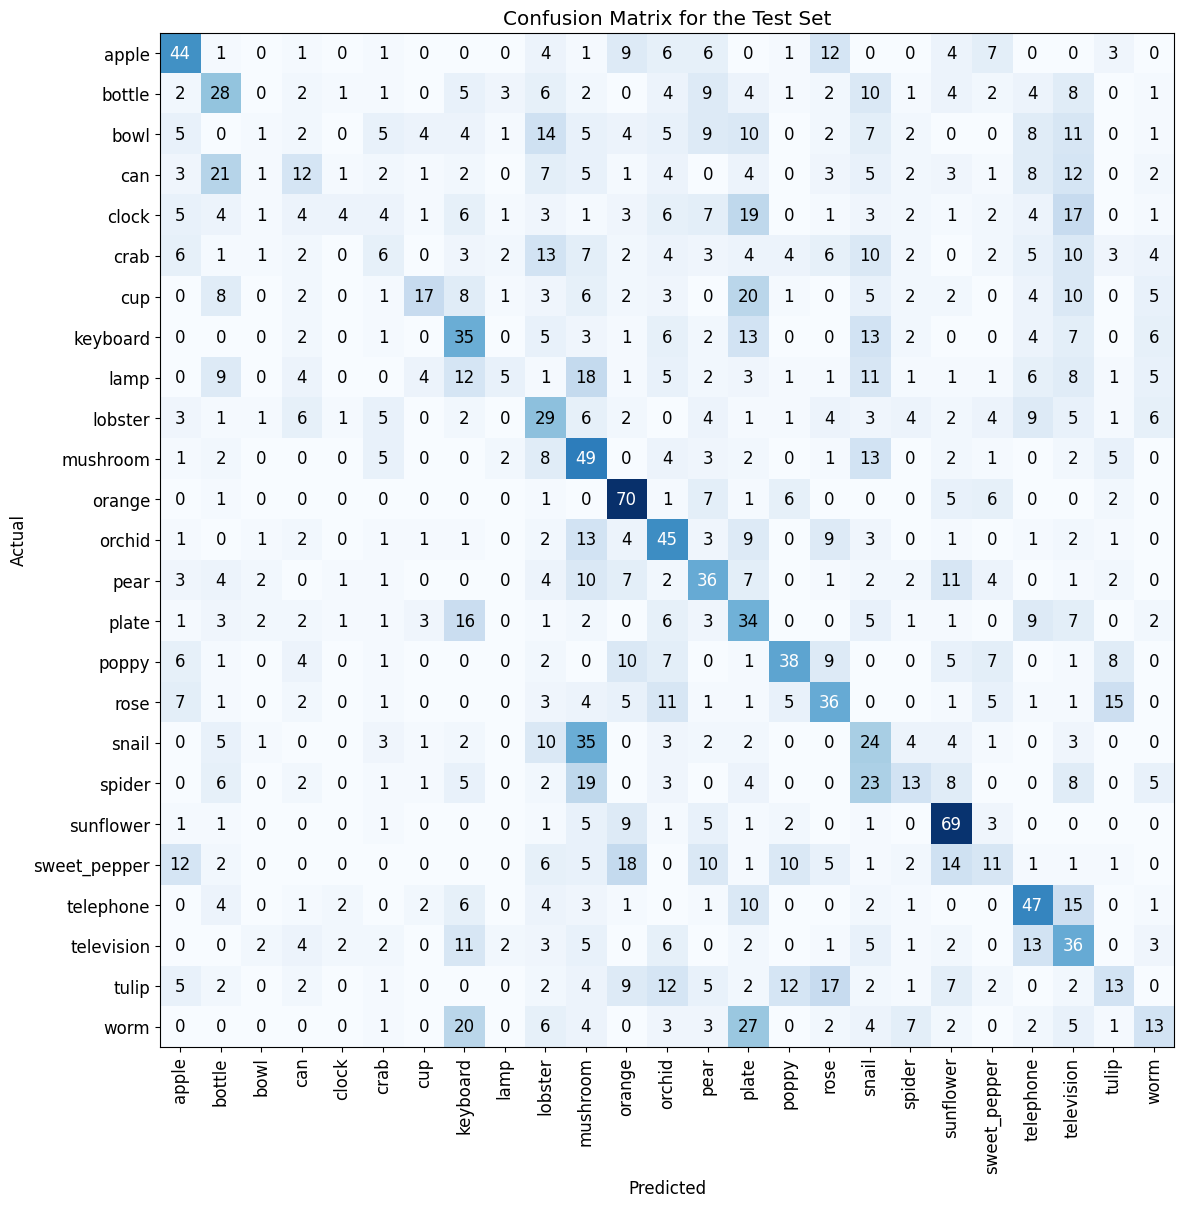

In [ ]:
#1.5 Testing the model
test_dl = learn_2.dls.test_dl(files_test,with_labels=True)

preds, targs = learn_2.get_preds(dl=test_dl)

# We compute the confusion matrix and Accuracy for Test
interp = ClassificationInterpretation.from_learner(learn_2, 1, test_dl)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)


**1. Discussion on SimpleNet2**

We see that there is a slight increase in the validation accuracy compared to the original SimpleNet; going from 21% to 26%.

Looking at the plots, we see both training and validation losses are decreasing smoothly and remain quite close to each other throughout the training process. This is a good sign as it indicates that the model is learning effectively.
There is no evidence of overfitting in the loss plot, as the validation loss is not increasing or diverging from the training loss.

Also, it seems like the model can benefit from further training by looking at the plots. So it would be better if the epochs were more than 5.

This increase in accuracies suggests that there is a slight increase in performance compared to the SimpleNet and the architectural changes that were made have had a positive effect on the model's ability to classify the validation data correctly.

In the next section, I'll try to make the model more complex, adding more convolutional layers and increasing the depth of the network even more to see if we can get better performance. Also, the number of epochs is going to increase as it was seen that it would be beneficial if the model had more time to learn.

**2. New cnn architecture, SimpleNet3**

First, again like simpleNet2, we have two 3x3 convolutions with padding. By not reducing the image size immediately, we can build deeper networks. As I explained, having several layers that maintain the original image size can allow the network to develop a richer feature representation before reducing dimensionality.

Second, in the next layers, I use a 1x1 convolution with zero padding, before using two back-to-back 3x3 kernels. By using 1x1 convolutions in our model, we preserve spatial dimension. By adding a 1X1 conv layer before the 3x3 Conv, while keeping the height and width of the feature map, we have reduced the number of operations. This will reduce the computational needs and in turn, will end up being more efficient while we could make our network deeper. Without adding to the computational complexity, 1x1 kernels introduce additional non-linearities into the network (they are followed by activation functions), which can help the network learn more complex patterns.

Next, we have maxpooling, in which I used padding of 1, to preserve more of the dimension, and to be able to add more convolution layers later.

Following the maxpooling, I repeated the 1x1 and two 3x3 kernels identical to before.

In the end, again, we have three FC layers, to decrease the features from 4410 (7x7x90) to 1000 to 500 and to 25 in the end.

In [ ]:
# 2.1 New SimpleNet3 model
simpleNet3 = sequential(
    # Increase initial depth and utilize 3x3 kernels for better feature extraction
    nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(3,3), stride=1, padding=1), # output:32x32 - from 3 channels to 20
    nn.ReLU(),
    nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3,3), stride=1, padding=1), # output: 32x32 - from 20 channels to 30
    nn.ReLU(),

    # First pooling to reduce spatial dimensions
    nn.MaxPool2d(kernel_size=(2,2), stride=2), # output: 16x16, 30 channels

    # Transition to even deeper layers with 1x1 and 3x3 kernels
    nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(1,1), stride=1, padding=0), # output: 16x16 - from 30 channels to 40
    nn.ReLU(),
    nn.Conv2d(in_channels=40, out_channels=50, kernel_size=(3,3), stride=1, padding=0), # output: 14x14 - from 40 channels to 50
    nn.ReLU(),
    nn.Conv2d(in_channels=50, out_channels=60, kernel_size=(3,3), stride=1, padding=0), # output: 12x12 - from 50 to 60 channels
    nn.ReLU(),

    # Final max pooling with stride of 1 to reduce dimensions before fully connected layers
    nn.MaxPool2d(kernel_size=(2,2), stride=1), # output: 11x11

    nn.Conv2d(in_channels=60, out_channels=70, kernel_size=(1,1), stride=1, padding=0), # output: 11x11 - from 60 channels to 70
    nn.ReLU(),
    nn.Conv2d(in_channels=70, out_channels=80, kernel_size=(3,3), stride=1, padding=0), # output: 9x9 - from 70 channels to 80
    nn.ReLU(),
    nn.Conv2d(in_channels=80, out_channels=90, kernel_size=(3,3), stride=1, padding=0), # output: 7x7 - from 80 channels to 90
    nn.ReLU(),

    # Flatten the output for fully connected layers
    nn.Flatten(),

    # FC layers
    nn.Linear(in_features=4410, out_features=1000),  # 4410 = 7x7x90
    nn.ReLU(),

    nn.Linear(in_features=1000, out_features=500),
    nn.ReLU(),

    nn.Linear(in_features=500, out_features=25),

)

0.001737800776027143


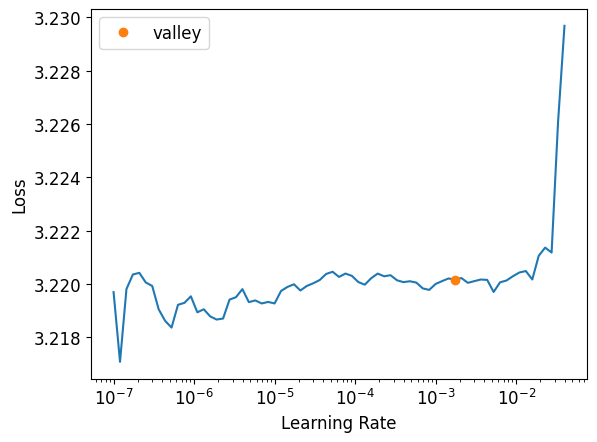

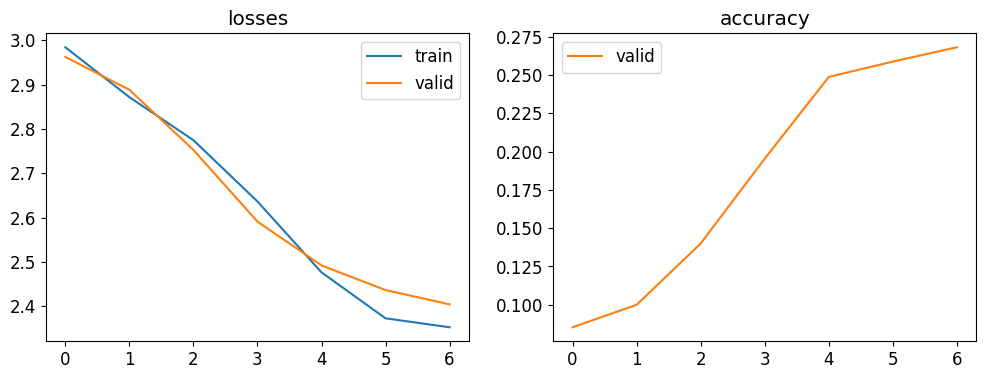

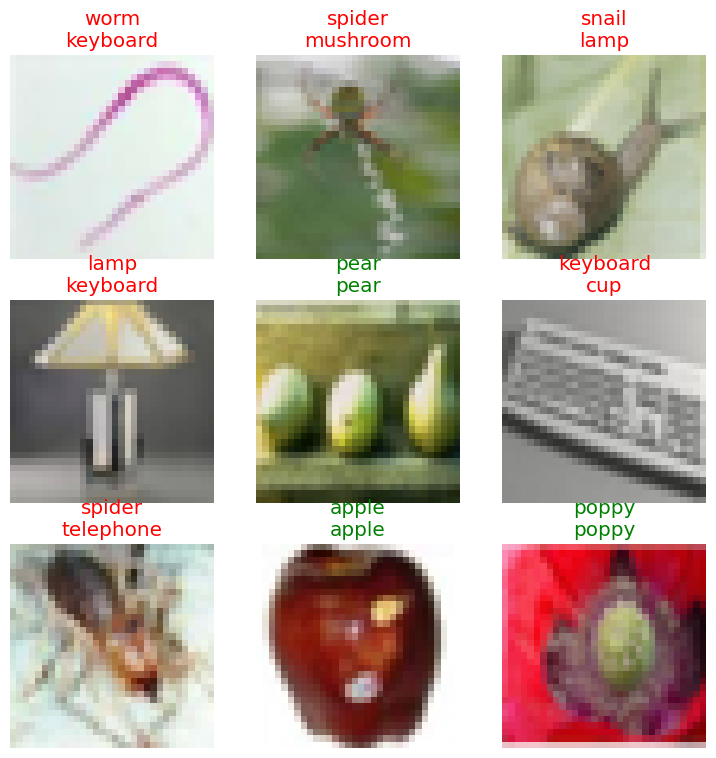

In [ ]:
#2.2 Learner, dls2 is used (with augmentation, epoch = 7)

# Data Loader
dls = db.dataloaders(path, bs=32)

learn_4 = Learner(dls, simpleNet3, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

#3.3 Training
max4=learn_4.lr_find()
print(max4[0])

learn_4.fit_one_cycle(n_epoch=7, lr_max=max4[0])

# Evaluating the model
learn_4.recorder.plot_metrics()

learn_4.show_results()

Train Accuracy
30.081481481481482


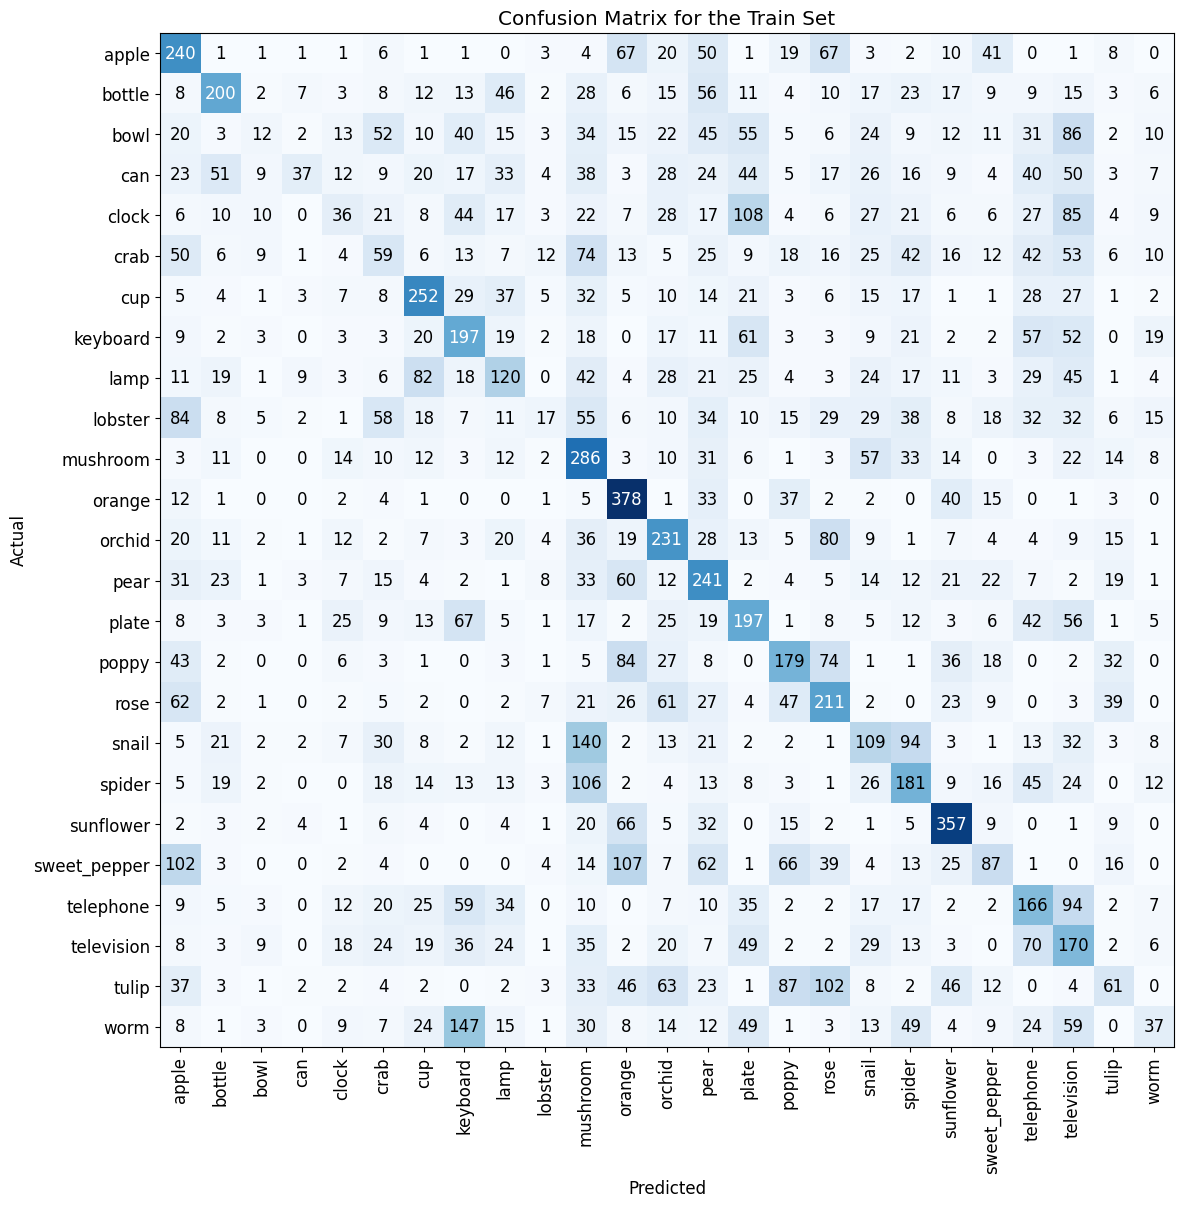

In [ ]:
#2.4 We compute the confusion matrix and Accuracy for Train set
interp = ClassificationInterpretation.from_learner(learn_4, 1, dls.train)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Train Set')
print('Train Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

Test Accuracy
29.84


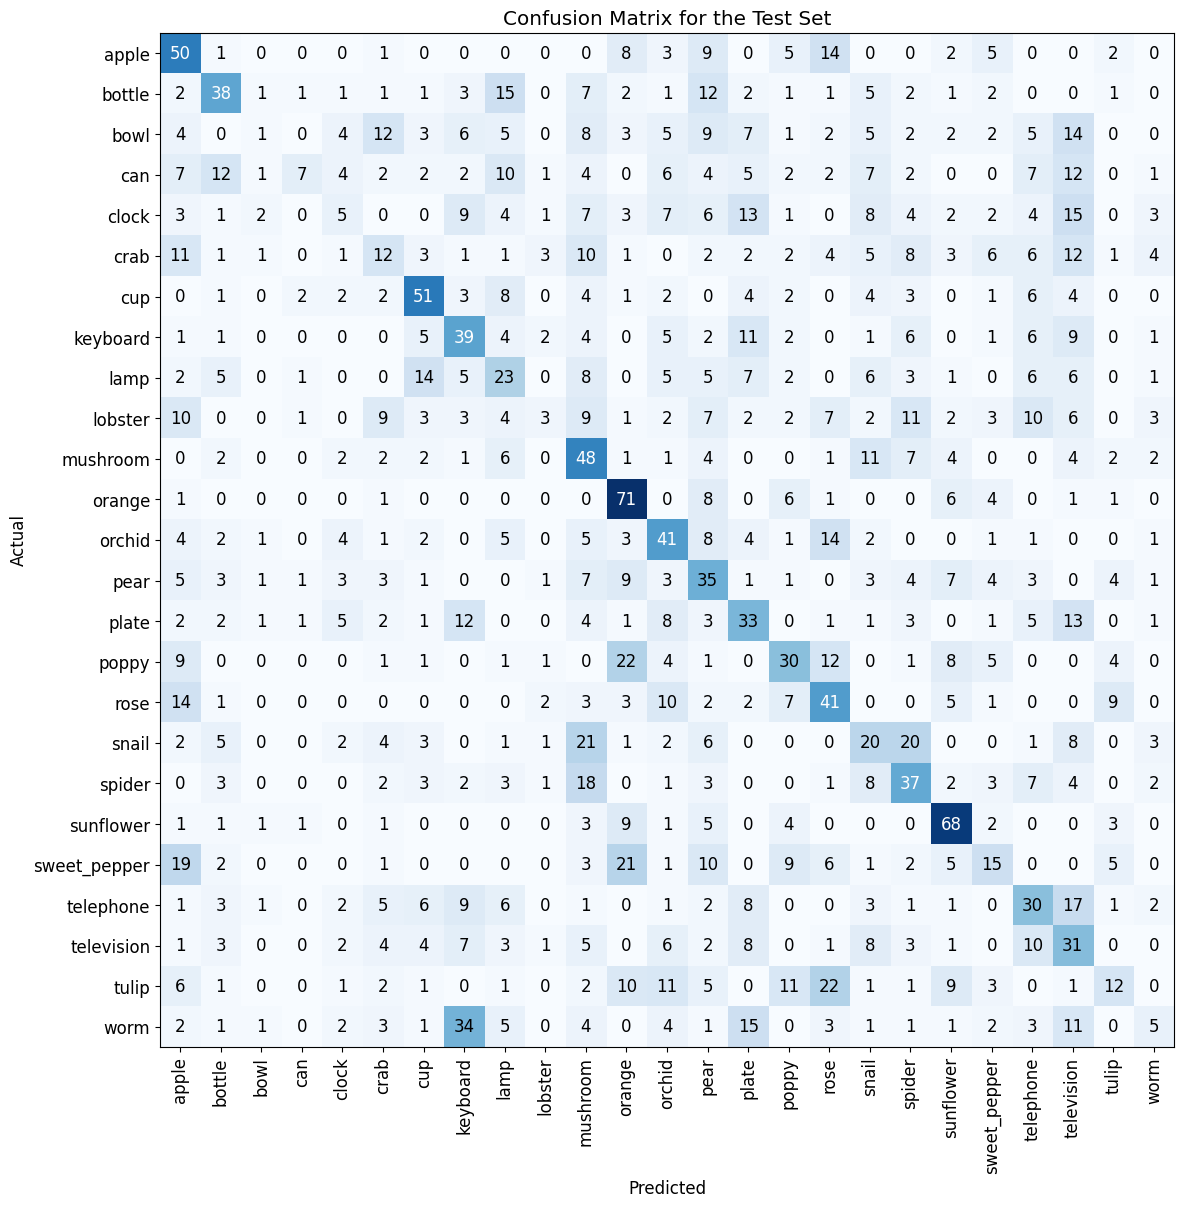

In [ ]:
#2.5 Testing the model
test_dl = learn_4.dls.test_dl(files_test,with_labels=True)

preds, targs = learn_4.get_preds(dl=test_dl)

# We compute the confusion matrix and Accuracy for Test
interp = ClassificationInterpretation.from_learner(learn_4, 1, test_dl)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

**2. Discussion on SimpleNet3**

Looking at the plots, we see that the training and validation losses continue to decrease, which indicates that the model is learning from the data. They are closely following each other, which is a good sign that the model is generalizing well and there isn't a sign of overfitting.

The validation accuracy plot shows a steady increase in performance as the training progresses, which again is a good sign.

Training Accuracy is around 30% which is a moderate accuracy and suggests that the model is learning from the training data but there is still room for improvement, but there is an improvement over the previous architecture's training accuracy.
Validation Accuracy is around 27% which is slightly lower than the training accuracy, but relatively close, which suggests the model is generalizing fairly well. This is an improvement over the previous validation accuracy.
Test Accuracy is 29.8%, which is close to the training accuracy, which is desirable. It shows that the model's performance is consistent across different datasets.

Comparing SimpleNet2 and SimpleNet3, I chose to continue the exercise with SimpleNet3, as it performs well on the dataset. From now on the workflow is as bellow:

1. 3 - SimpleNet3 + Batch Normalization only (SimpleNet4)
2. 4 - SimpleNet3 + Drop Out only (SimpleNet5)
3. 5 - SimpleNet3 + Batch Normalization + Drop Out (SimpleNet6)

**3.  SimpleNet4 = SimpleNet3 + Batch Normalization only**

Batch normalization is a technique to improve the training of deep neural networks. It was introduced in a 2015 paper by Sergey Ioffe and Christian Szegedy, with the primary goal of addressing the issue known as "internal covariate shift."

Internal Covariate Shift is the change in the distribution of network activations due to the change in network parameters during training. The idea is that if we stabilize the input values for each layer, we can improve the training.

BN method wants to make sure that the data stays scaled while it's training; aiming to mitigate the internal covariate shift by performing a normalization step for each mini-batch.

Also, note that for each BN in each layer, we will have 2 new parameters that the network has to learn.

We use nn.BatchNorm2d() function in the network, which takes the number of channels in that layer as the input.

In [ ]:
# 3.1 New SimpleNet4 model (simpleNet3 + BN)
simpleNet4 = sequential(
    # Increase initial depth and utilize 3x3 kernels for better feature extraction
    nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(3,3), stride=1, padding=1), #32x32
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3,3), stride=1, padding=1), #32x32
    nn.BatchNorm2d(30),
    nn.ReLU(),

    # First pooling to reduce spatial dimensions
    nn.MaxPool2d(kernel_size=(2,2), stride=2), #16x16

    # Transition to even deeper layers with 1x1 and 3x3 kernels
    nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(1,1), stride=1, padding=0), #16x16
    nn.BatchNorm2d(40),
    nn.ReLU(),
    nn.Conv2d(in_channels=40, out_channels=50, kernel_size=(3,3), stride=1, padding=0), #14x14
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.Conv2d(in_channels=50, out_channels=60, kernel_size=(3,3), stride=1, padding=0), #12x12
    nn.BatchNorm2d(60),
    nn.ReLU(),

    # Final max pooling to reduce dimensions before fully connected layers
    nn.MaxPool2d(kernel_size=(2,2), stride=1), #11x11

    nn.Conv2d(in_channels=60, out_channels=70, kernel_size=(1,1), stride=1, padding=0), #11x11
    nn.BatchNorm2d(70),
    nn.ReLU(),
    nn.Conv2d(in_channels=70, out_channels=80, kernel_size=(3,3), stride=1, padding=0), #9x9
    nn.BatchNorm2d(80),
    nn.ReLU(),
    nn.Conv2d(in_channels=80, out_channels=90, kernel_size=(3,3), stride=1, padding=0), #7x7
    nn.BatchNorm2d(90),
    nn.ReLU(),

    # Flatten the output for fully connected layers
    nn.Flatten(),

    # FC Layers
    nn.Linear(in_features=4410, out_features=1000),
    nn.ReLU(),

    nn.Linear(in_features=1000, out_features=500),
    nn.ReLU(),

    nn.Linear(in_features=500, out_features=25),

)

6.30957365501672e-05


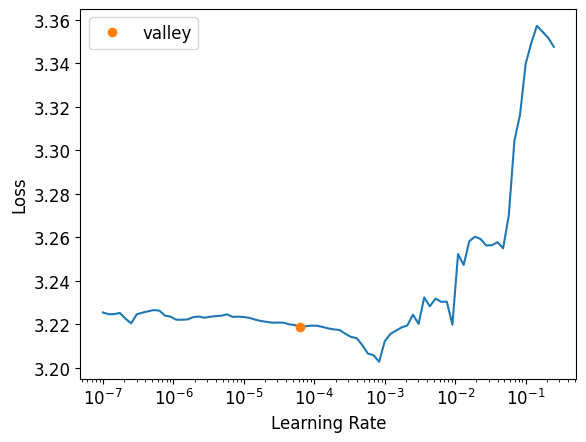

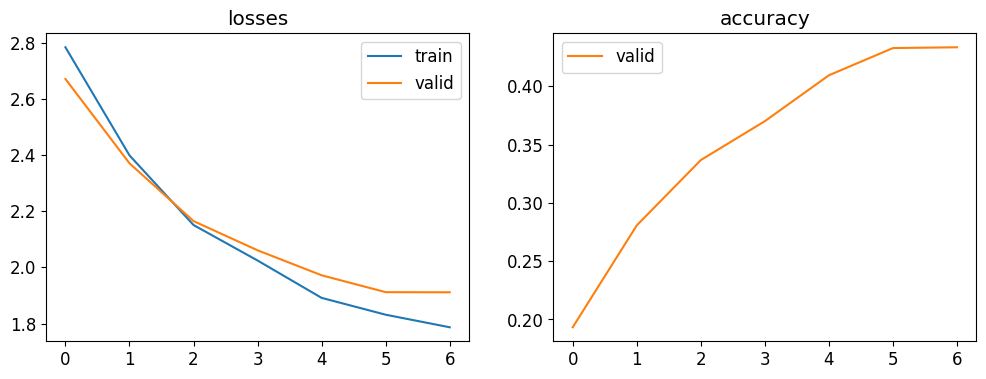

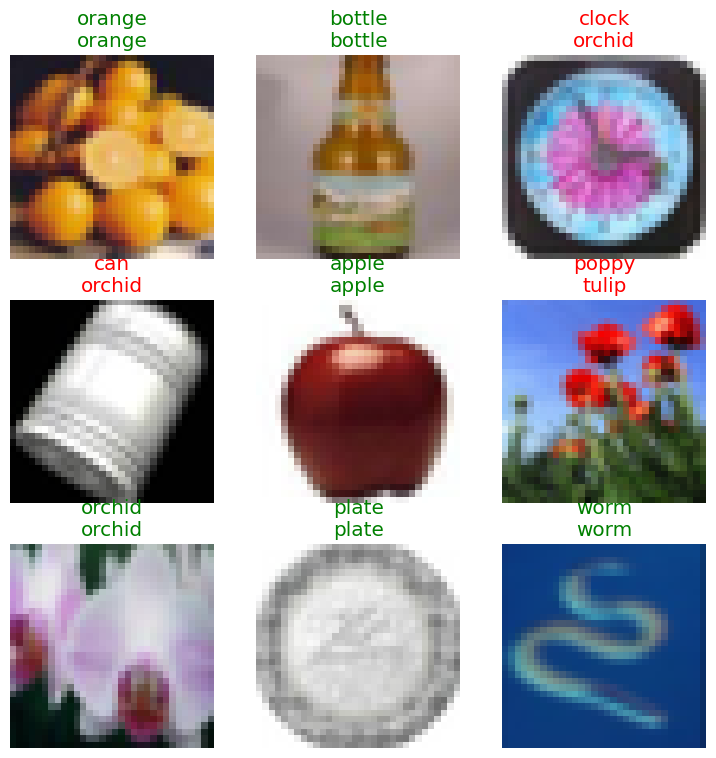

In [ ]:
#3.2 Learner, dls is used (with augmentation, epoch = 7)
# Data Loader
dls = db.dataloaders(path, bs=32)

learn_5 = Learner(dls, simpleNet4, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

#3.3 Training
max5=learn_5.lr_find()
print(max5[0])

learn_5.fit_one_cycle(n_epoch=7, lr_max=max5[0])

# Evaluating the model
learn_5.recorder.plot_metrics()

learn_5.show_results()

Train Accuracy
48.86666666666667


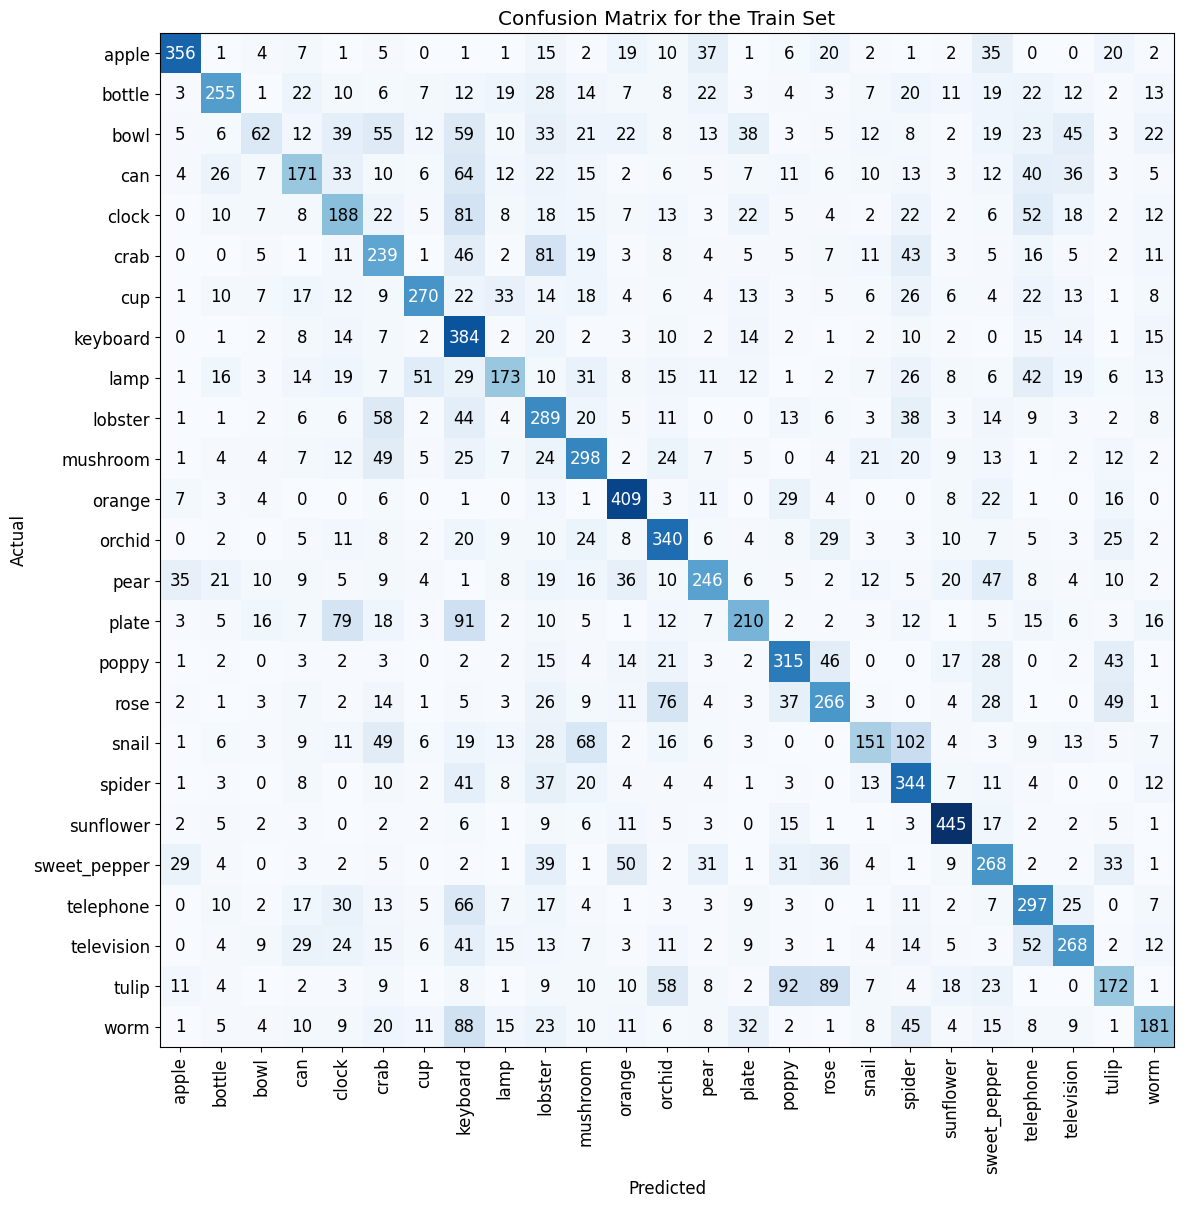

In [ ]:
#3.4 We compute the confusion matrix and Accuracy for Train set
interp = ClassificationInterpretation.from_learner(learn_5, 1, dls.train)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Train Set')
print('Train Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

Test Accuracy
49.559999999999995


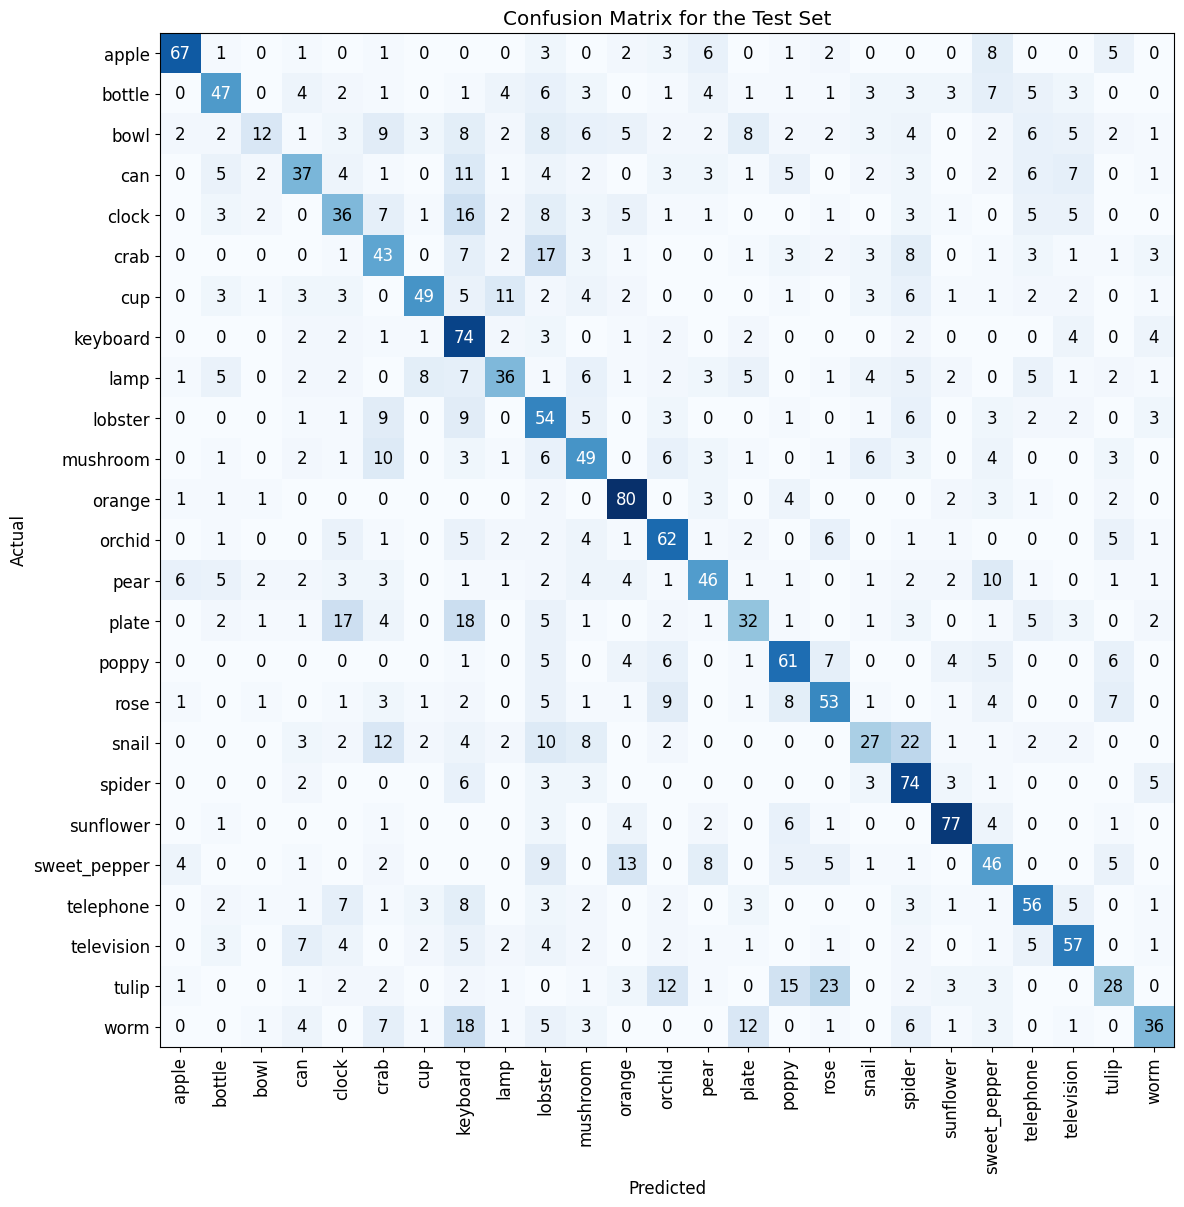

In [ ]:
#3.5 Testing the model
test_dl = learn_5.dls.test_dl(files_test,with_labels=True)

preds, targs = learn_5.get_preds(dl=test_dl)

# We compute the confusion matrix and Accuracy for Test
interp = ClassificationInterpretation.from_learner(learn_5, 1, test_dl)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

**3. Discussion on SimpleNet4**

Looking at the plots, we see that both the training and validation loss are consistently decreasing, with the validation loss following the training loss closely. This indicates a suitable training process without signs of overfitting.

The validation accuracy shows a steady and significant increase, with no declines. This indicates that the model is benefiting from each epoch of training.

Training Accuracy is around 48.8% which is an improvement in training accuracy, compared to the previous architecture without batch normalization. This indicates that the model's learning capacity has been enhanced.

Validation Accuracy is around 43% which is good compared to the previous architectures and shows that the model is generalizing well.

Test Accuracy is around 49.5% which is higher than the validation accuracy and very close to the training accuracy, which is good. It indicates that the model is performing consistently across both seen (training) and unseen (validation, test) data.

In the next section, we will see how SimpleNet3 + Drop out performs.

**4. SimpleNet5 = SimpleNet3 + Drop Out only**

The Dropout Layer is a regularization technique used in CNN to help improve the data and also prevent overfitting. Overfitting occurs when a model shows high performance on the training data but struggles to generalize well to unseen data.
The dropout layer, randomly deactivates a portion of input units during each training update; meaning that during forward propogation, certain neurons in the network are deactivated, based on a specific probability.

In the original paper that proposed dropout layers, by Hinton (2012), dropout with probability of p=0.5 was used on each of the fully connected layers before the output.

However, I didn't want the dropout to be severe, therefore I started with a middle ground with p = 0.25 after each FC layer.

In [ ]:
# 4.1 New SimpleNet5 model, WITH dropout, WITHOUT BN
simpleNet5 = sequential(
    # Increase initial depth and utilize 3x3 kernels for better feature extraction
    nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(3,3), stride=1, padding=1), #32x32
    nn.ReLU(),
    nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3,3), stride=1, padding=1), #32x32
    nn.ReLU(),

    # First pooling to reduce spatial dimensions
    nn.MaxPool2d(kernel_size=(2,2), stride=2), #16x16

    # Transition to even deeper layers
    nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(1,1), stride=1, padding=0), #16x16
    nn.ReLU(),
    nn.Conv2d(in_channels=40, out_channels=50, kernel_size=(3,3), stride=1, padding=0), #14x14
    nn.ReLU(),
    nn.Conv2d(in_channels=50, out_channels=60, kernel_size=(3,3), stride=1, padding=0), #12x12
    nn.ReLU(),

    # Final max pooling to reduce dimensions before fully connected layers
    nn.MaxPool2d(kernel_size=(2,2), stride=1), #11x11

    nn.Conv2d(in_channels=60, out_channels=70, kernel_size=(1,1), stride=1, padding=0), #11x11
    nn.ReLU(),
    nn.Conv2d(in_channels=70, out_channels=80, kernel_size=(3,3), stride=1, padding=0), #9x9
    nn.ReLU(),
    nn.Conv2d(in_channels=80, out_channels=90, kernel_size=(3,3), stride=1, padding=0), #7x7
    nn.ReLU(),

    # Flatten the output for fully connected layers
    nn.Flatten(),

    # FC Layers
    nn.Linear(in_features=4410, out_features=1000),
    nn.ReLU(),
    nn.Dropout2d(0.25),

    nn.Linear(in_features=1000, out_features=500),
    nn.ReLU(),
    nn.Dropout2d(0.25),

    nn.Linear(in_features=500, out_features=25),
)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.0003981071640737355


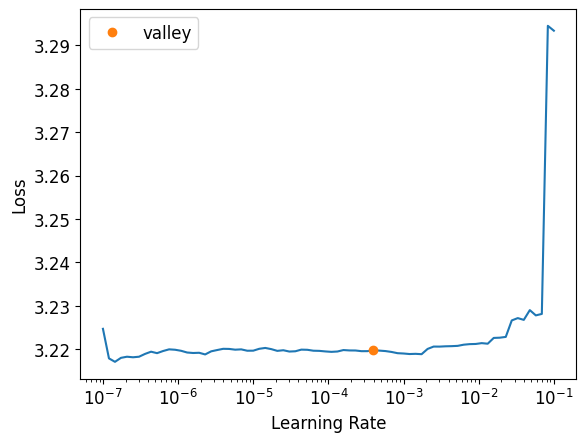

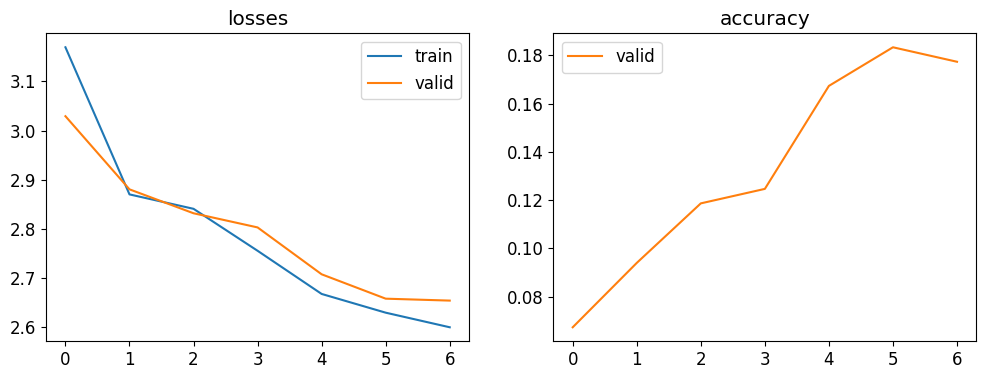

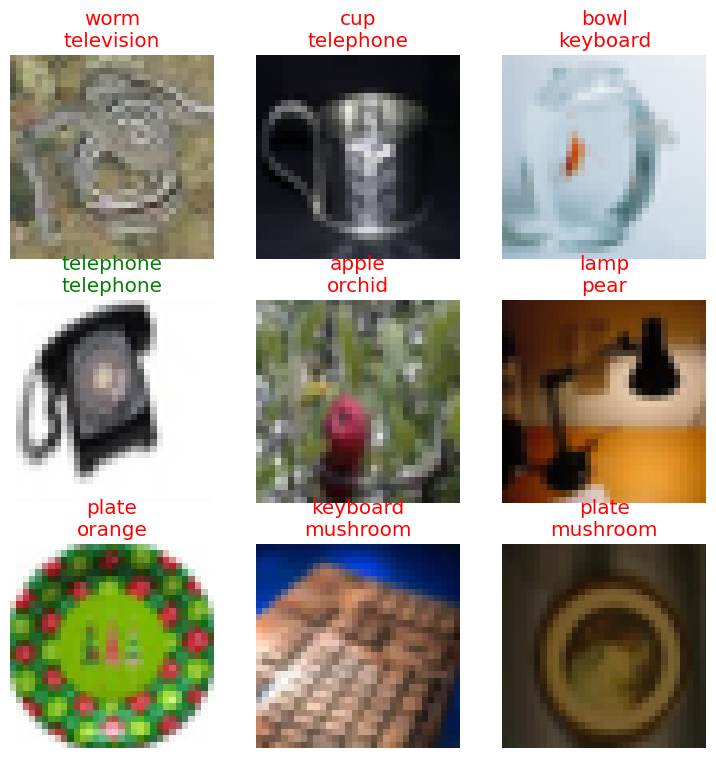

In [ ]:
#4.2 Learner, dls is used (with augmentation)

dls = db.dataloaders(path, bs=32)

learn_7 = Learner(dls, simpleNet5, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

#4.3 Training
max7=learn_7.lr_find()
print(max7[0])

learn_7.fit_one_cycle(n_epoch=7, lr_max=max7[0])

# Evaluating the model
learn_7.recorder.plot_metrics()

learn_7.show_results()

Train Accuracy
20.84444444444444


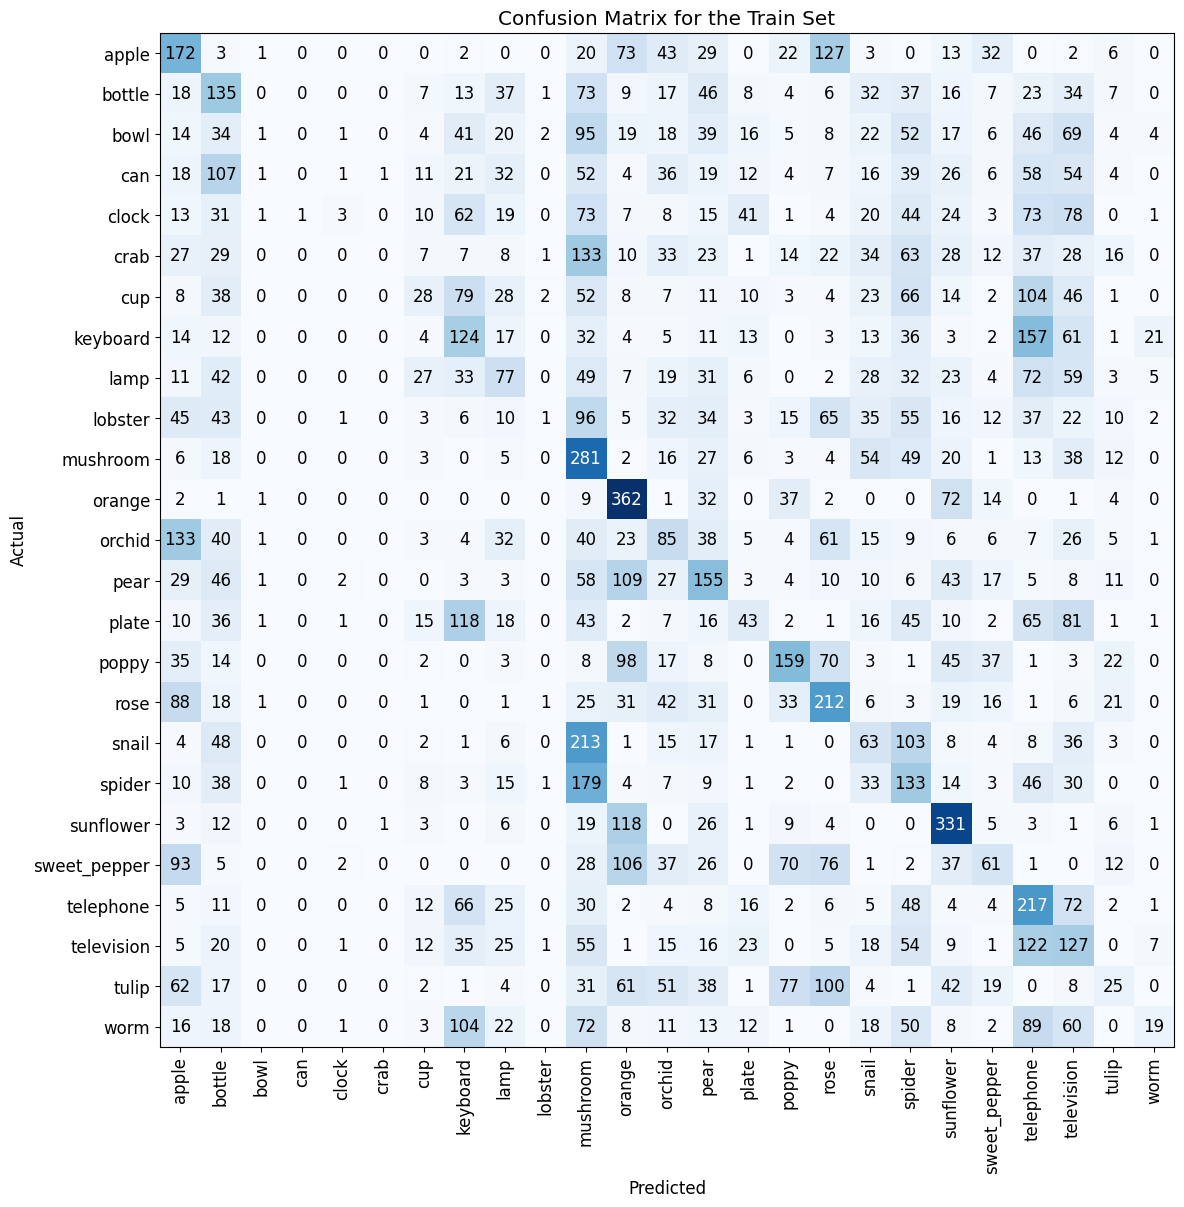

In [ ]:
#4.4 We compute the confusion matrix and Accuracy for Train set
interp = ClassificationInterpretation.from_learner(learn_7, 1, dls.train)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Train Set')
print('Train Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

Test Accuracy
21.36


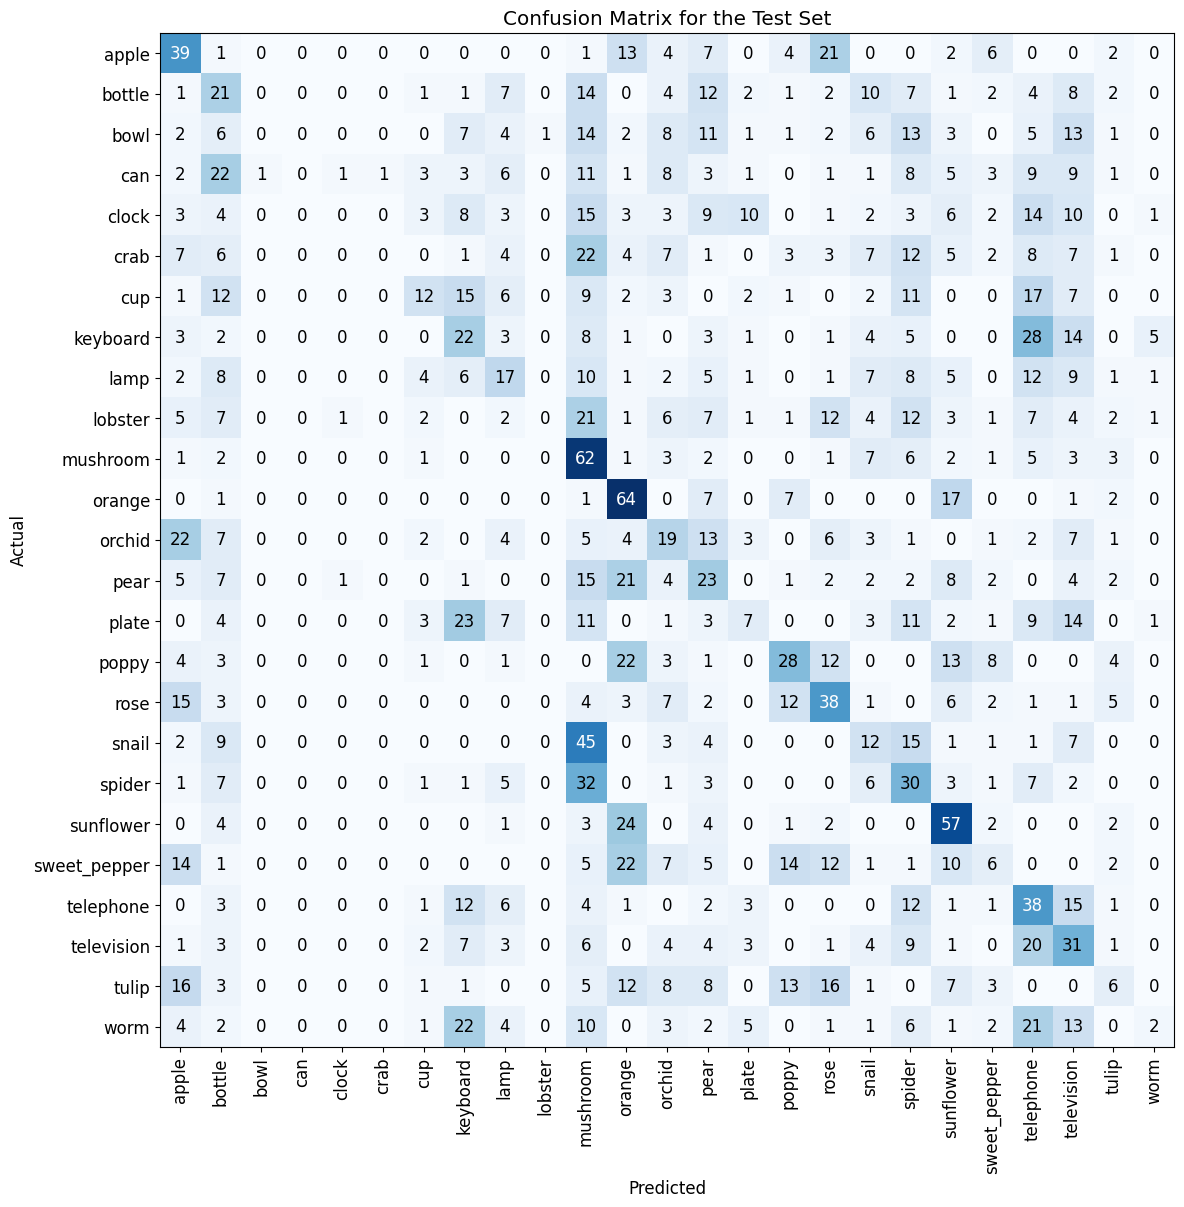

In [ ]:
#4.5 Testing the model
test_dl = learn_7.dls.test_dl(files_test,with_labels=True)

preds, targs = learn_7.get_preds(dl=test_dl)

# We compute the confusion matrix and Accuracy for Test
interp = ClassificationInterpretation.from_learner(learn_7, 1, test_dl)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

**4. Discussion on SimpleNet4 (with dropout, without BN)**

Removing the batch normalization layer and introducing dropout has decreased the accuracy significantly, we can even see that in the last epoch we have a slight decrease in validation accuracy.

Impact of Removing Batch Normalization:

BN can significantly accelerate training by normalizing the inputs of each layer. This helps to stabilize the learning process and can lead to faster convergence. Without BN, the network might be struggling with the learning process.

Dropout is a regularization technique that randomly sets a fraction of the input units to 0 at each update during training time, which helps to prevent overfitting. However, if the dropout rate is too high the network might lose critical information during training, which could negatively impact the model's ability to learn from the training data.
If the remaining network (after dropout) isn't sufficient to model the complexity of the data, this can also result in not performing well.

The drop in performance can likely be connected to the combined effect of the removal of BN and the possible over-regularization due to dropout. Without the stabilizing effect of BN, the learning process can become more difficult, and adding dropout might have further limited the network's capacity to learn.

Training Time: With dropout added, the network may need more epochs to converge because it's getting less information per training case. we may need to train for more epochs to see the improvement.

However, we won't increase the epochs more than 7, but we can see the combined effect of BN + DO in the next section.

**5. SimpleNet6 = SimpleNet3 + Batch Normalization + Drop Out**

In [ ]:
# 5.1 New SimpleNet6 model - BN + DO
simpleNet6 = sequential(
    # Increase initial depth and utilize 3x3 kernels for better feature extraction
    nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(3,3), stride=1, padding=1), #32x32
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3,3), stride=1, padding=1), #32x32
    nn.BatchNorm2d(30),
    nn.ReLU(),

    # First pooling to reduce spatial dimensions
    nn.MaxPool2d(kernel_size=(2,2), stride=2), #16x16

    # Transition to even deeper layers
    nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(1,1), stride=1, padding=0), #16x16
    nn.BatchNorm2d(40),
    nn.ReLU(),
    nn.Conv2d(in_channels=40, out_channels=50, kernel_size=(3,3), stride=1, padding=0), #14x14
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.Conv2d(in_channels=50, out_channels=60, kernel_size=(3,3), stride=1, padding=0), #12x12
    nn.BatchNorm2d(60),
    nn.ReLU(),

    # Final max pooling to reduce dimensions before fully connected layers
    nn.MaxPool2d(kernel_size=(2,2), stride=1), #11x11

    nn.Conv2d(in_channels=60, out_channels=70, kernel_size=(1,1), stride=1, padding=0), #11x11
    nn.BatchNorm2d(70),
    nn.ReLU(),
    nn.Conv2d(in_channels=70, out_channels=80, kernel_size=(3,3), stride=1, padding=0), #9x9
    nn.BatchNorm2d(80),
    nn.ReLU(),
    nn.Conv2d(in_channels=80, out_channels=90, kernel_size=(3,3), stride=1, padding=0), #7x7
    nn.BatchNorm2d(90),
    nn.ReLU(),

    # Flatten the output for fully connected layers
    nn.Flatten(),

    # FC Layers
    nn.Linear(in_features=4410, out_features=1000),
    nn.ReLU(),
    nn.Dropout2d(0.25),

    nn.Linear(in_features=1000, out_features=500),
    nn.ReLU(),
    nn.Dropout2d(0.25),

    nn.Linear(in_features=500, out_features=25),

)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.00010964782268274575


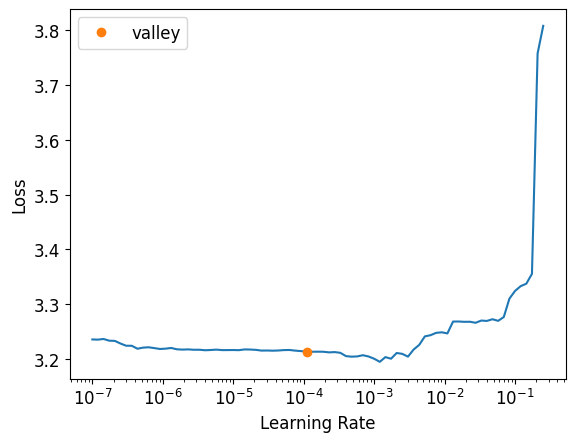

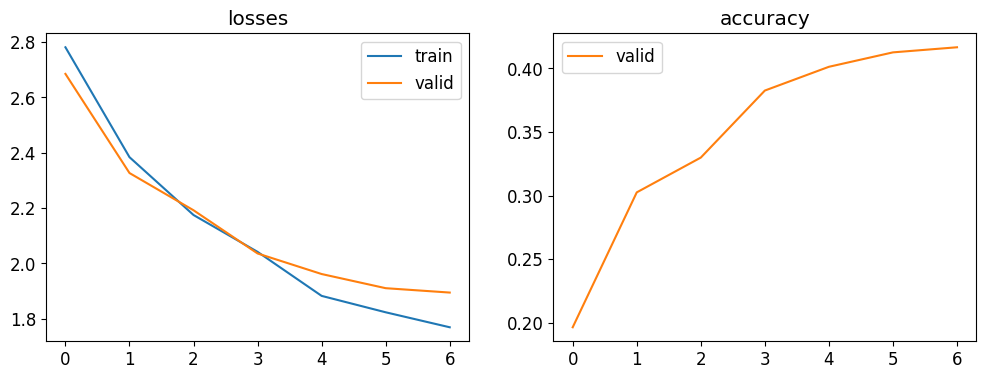

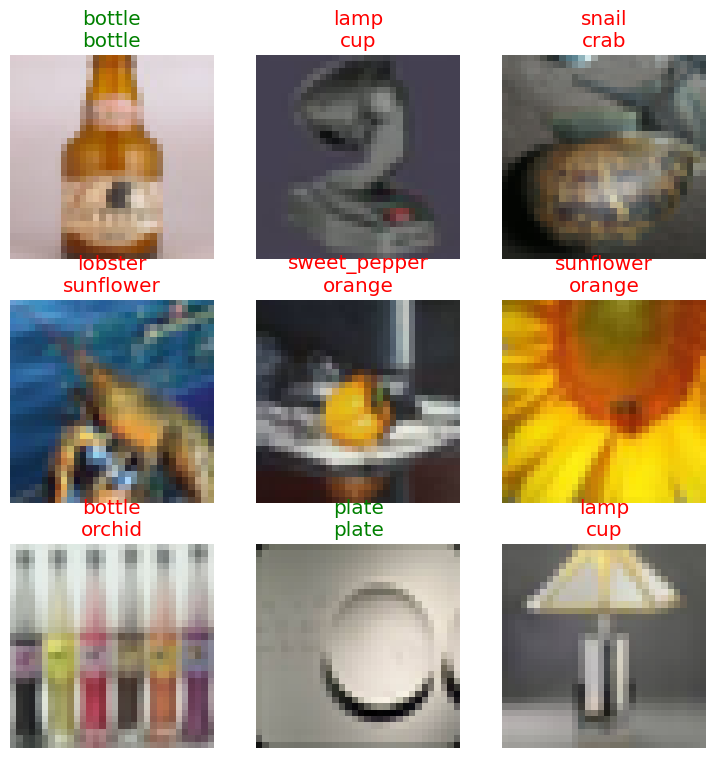

In [ ]:
#5.2 Learner, dls is used with augmentation

dls = db.dataloaders(path, bs=32)

learner_10 = Learner(dls, simpleNet6, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

#5.3 Training
max10=learner_10.lr_find()
print(max10[0])

learner_10.fit_one_cycle(n_epoch=7, lr_max=max10[0])

# Evaluating the model
learner_10.recorder.plot_metrics()

learner_10.show_results()

Train Accuracy
50.27407407407407


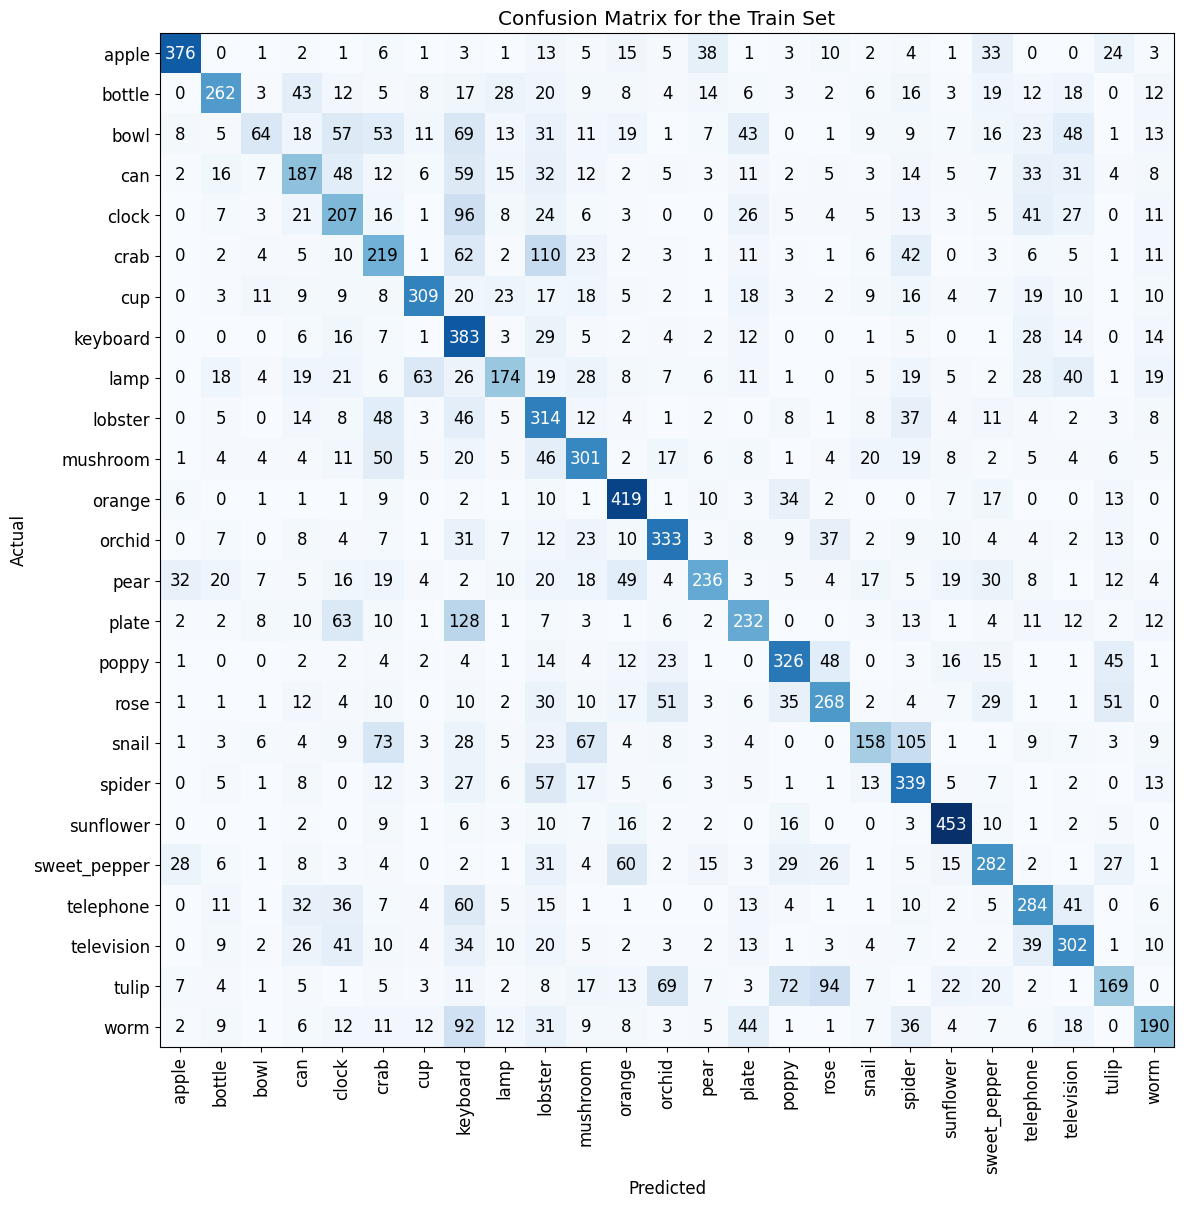

In [ ]:
#5.4 We compute the confusion matrix and Accuracy for Train set
interp = ClassificationInterpretation.from_learner(learner_10, 1, dls.train)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Train Set')
print('Train Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

Test Accuracy
49.559999999999995


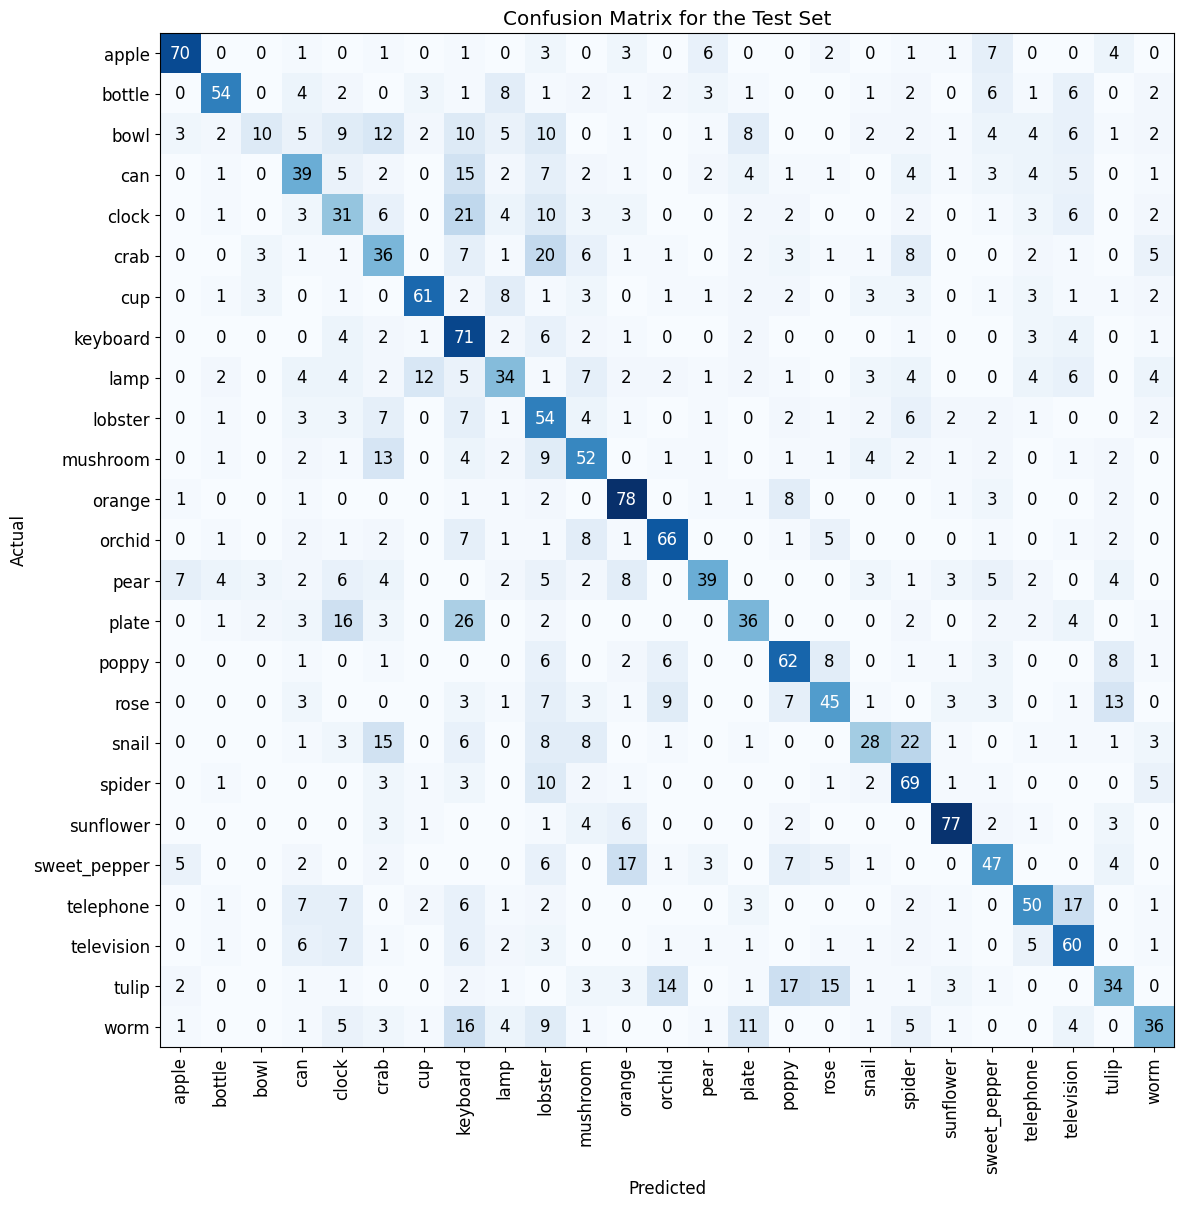

In [ ]:
#5.5 Testing the model
test_dl = learner_10.dls.test_dl(files_test,with_labels=True)

preds, targs = learner_10.get_preds(dl=test_dl)

# We compute the confusion matrix and Accuracy for Test
interp = ClassificationInterpretation.from_learner(learner_10, 1, test_dl)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

**5.Discussion on SimpleNet6**

We see great improvement compared to the previous section.

The training and validation loss curves show a steady decrease, which is a positive sign that the model is learning effectively. There is no indication of overfitting as the validation loss continues to track closely with the training loss throughout the training epochs.

Training Accuracy is around 50.3% which is a high training accuracy compared to the other models, suggesting that the model is able to fit well to the training data.
Validation Accuracy is around 41% which is significantly better than the model with dropout only, indicating that the inclusion of BN helps the model generalize better.
Test Accuracy is 49.55% which is close to the training accuracy, indicating good generalization to the unseen test data. This is consistent with the idea that BN helps the model perform better on new data.

The validation accuracy curve shows a continual increase throughout the training epochs, without any significant drops, suggesting steady learning and model improvement over time.

Seeing that the accuracy is improving, it is suitable to experiment with an increased number of epochs, cause it seems that the network may benefit from having more time to train. Therefore, in the section I'll increase the epochs from 7 to 10.

**6. Training for more epochs**

Now that SimpleNet6 gave satisfactory results, let's increase the epochs from 7 to 10. Increasing the number of epochs can allow a model more time to learn and possibly improve its performance, especially if it hasn't yet reached a plateau in terms of loss or accuracy.

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.00013182566908653826


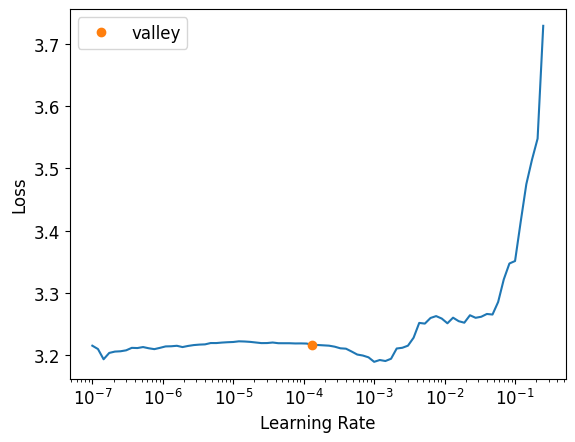

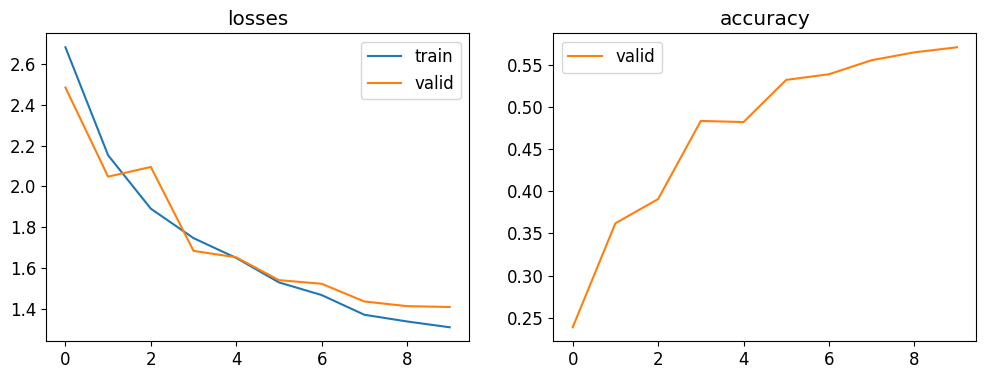

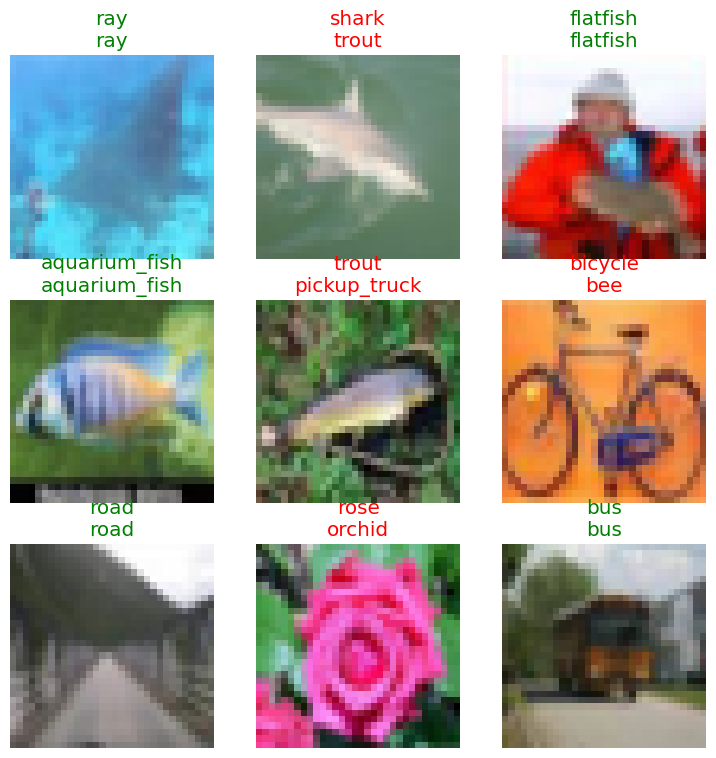

In [ ]:
#6.2 Learner, dls is used with augmentation

dls = db.dataloaders(path, bs=32) # With Data Augmentation

learner_123 = Learner(dls, simpleNet6, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

#6.3 Training
max123=learner_123.lr_find()
print(max123[0])

learner_123.fit_one_cycle(n_epoch=10, lr_max=max123[0])

# Evaluating the model
learner_123.recorder.plot_metrics()

learner_123.show_results()

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Accuracy
62.05185185185185


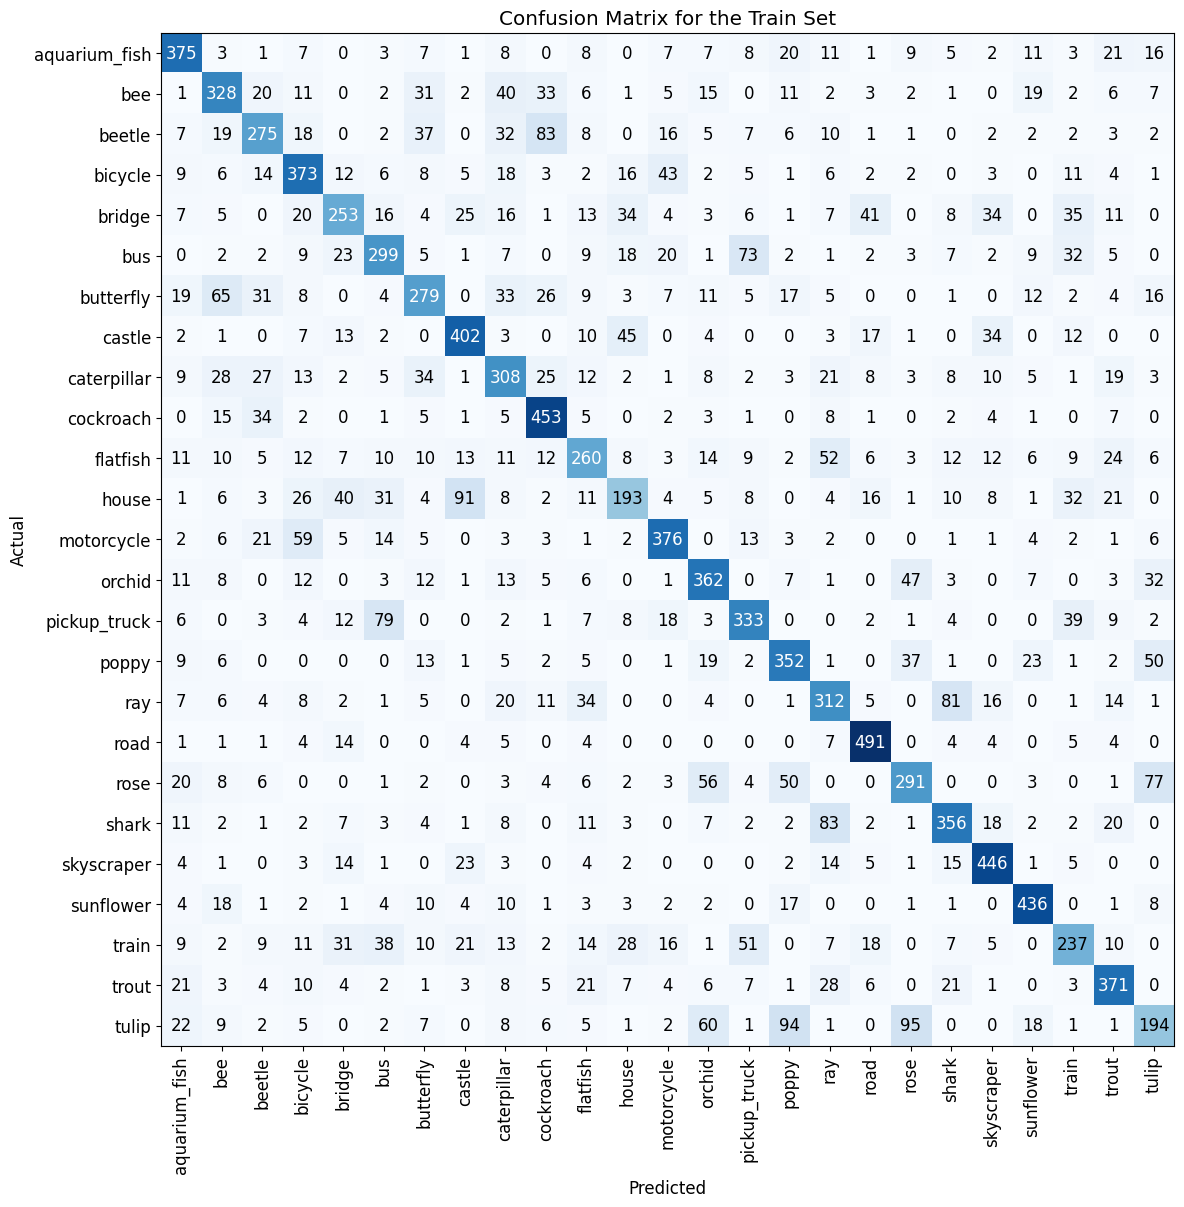

In [ ]:
#5.4 We compute the confusion matrix and Accuracy for Train set
interp = ClassificationInterpretation.from_learner(learner_123, 1, dls.train)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Train Set')
print('Train Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test Accuracy
64.0


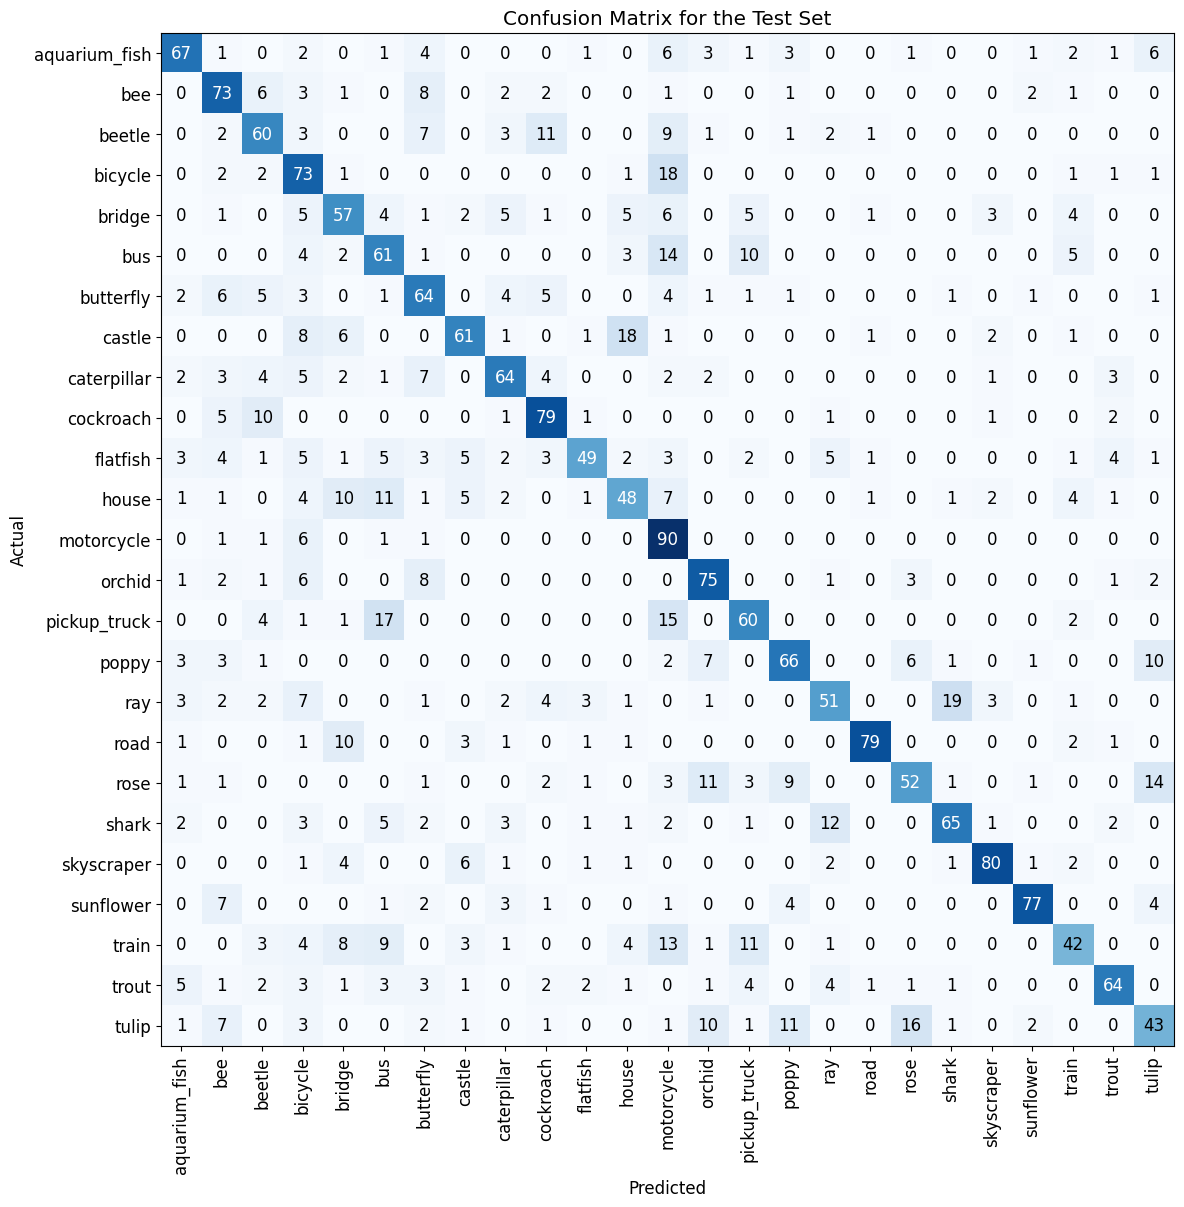

In [ ]:
#5.5 Testing the model
test_dl = learner_123.dls.test_dl(files_test,with_labels=True)

preds, targs = learner_123.get_preds(dl=test_dl)

# We compute the confusion matrix and Accuracy for Test
interp = ClassificationInterpretation.from_learner(learner_123, 1, test_dl)
cm = interp.confusion_matrix()
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

**6. Discussion**

It seems that increasing the epochs from 7 to 10 has had a positive impact on learning.
Both training and validation loss have continued to decrease, which is a good indication that the model is learning and improving its understanding of the data.
There's no sign of the validation loss increasing or a significant gap between the validation and train loss, which suggests that the model has not started to overfit. This is one of our concerns when we increase the number of epochs, which fortunately is not the case here.

The validation accuracy has increased significantly after more epochs, which suggests that the model was not fully converged at 7 epochs and needed more time to optimize.

Training Accuracy is around 62%, which is a fairly high accuracy compared to previous sections, which indicates strong learning.
Validation Accuracy is around 57% which is a significant improvement from previous architectures.
Test Accuracy is around 64% which is quite close to the training accuracy, suggesting that the model is generalizing well to new unseen data.

Given the results, I decided that this would be the final improved network.



**Conclusion**

The following table shows the experiments that were done on the SimpleNet network with the networks' corresponding accuracies in train, validation, and test.

<img src="https://drive.google.com/uc?export=view&id=1og96zC6jRvuVP86qUB2rgAduN5AveIAF" width="650" height="600">

Therefore, the final architecture would be as follows (Train data with augmentation, and epochs of 10):


<img src="https://drive.google.com/uc?export=view&id=1L_gQqTkUy5z0Lf-SCMAqAM7n_wFK3g8o" width="600" height="600">